In [39]:
#Importss
# import os
# os.environ['NUMEXPR_MAX_THREADS'] = 40
import numpy as np
from time import time
from tmu.models.classification.vanilla_classifier import TMClassifier
from scipy.sparse import lil_matrix
from skimage.util import view_as_windows
from sklearn.feature_extraction.text import CountVectorizer
import cv2
from skimage.transform import pyramid_gaussian, pyramid_laplacian, downscale_local_mean
import matplotlib.pyplot as plt #drawing plots
import matplotlib.patches as patches #drawing squares
from scipy.ndimage import rotate

import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

from tqdm import tqdm #runtime stats

import ssl

ssl._create_default_https_context = ssl._create_unverified_context
from keras.datasets import cifar10


In [40]:
#Parameters

#TM
epochs = 30
max_included_literals = 500
clauses = 50
T = int((np.sqrt(clauses)/2 + 2)*10)
s = 1.5
step = 1
visual_tokens = True
encode_to_hypervec = False

#Data
#trained_labels = np.array([0,1,2,3])
trained_labels = np.arange(10)
training_pool_size = 1000 # number of testing pictures loaded

#preprocessing
resolution = 4 # scaled colors to thermometer code size of..
patch_dim = [3,3]

# Dice Dataset parameters
Debug_dataset = True
train_size = training_pool_size
test_size = 300
window_top_left = (0, 0)
window_bottom_right = (32, 32)
dice_size = 12    

#Hypervector
scaling = 1
unique_patches = 2**9
hypervector_size = int(512*scaling)

#Encoding
bits = np.maximum(5, int(5*scaling))
indexes = np.arange(hypervector_size, dtype=np.uint32)
encoding = np.zeros((unique_patches, hypervector_size), dtype=np.uint32)
for i in range(unique_patches):
        selection = np.random.choice(indexes, size=(bits))
        encoding[i][selection] = 1
        
labels = ["Airplane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

        

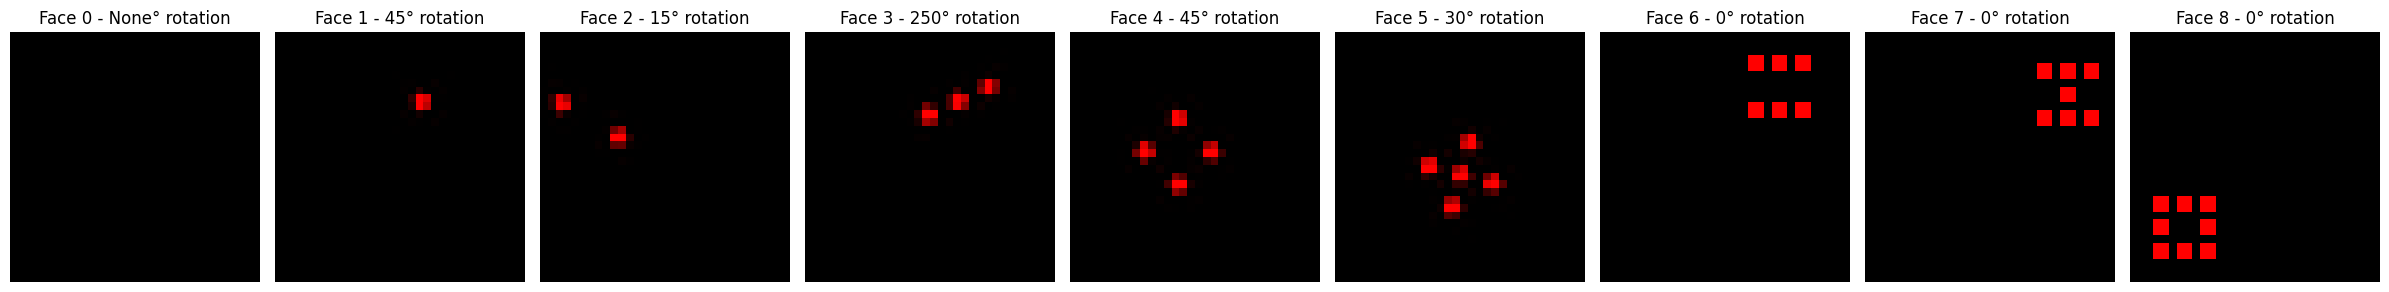

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random

def dice_image(value, top_left=(0, 0), bottom_right=(32, 32), dice_size=8, rand_placement=False, rotation_angle=None):
    img = np.zeros((32, 32, 3), dtype=np.uint8)
    
    # Relative dot size
    dot_size = dice_size // 6
    if dot_size<1:dot_size=1
    
    dot_color = (255, 0, 0)  # Red color
    
    if value not in range(0, 10):
        raise ValueError("Dice value should be between 0 and 10.")

    
    # Relative positions for the center of dice based on its value and dice size
    offset = dice_size // 4
    positions = {
        1: [(-offset, -offset)],
        2: [(-offset, -offset), (offset, offset)],
        3: [(-offset, -offset), (0, 0), (offset, offset)],
        4: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset)],
        5: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0)],
        6: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, -offset), (0, offset)],
        7: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0), (0, -offset), (0, offset)],
        8: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, -offset), (0, offset), (-offset, 0), (offset, 0)],
        9: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0), (0, -offset), (0, offset), (-offset, 0), (offset, 0)]
    }
    if rand_placement:
        # Generate a random position within the window for the center of the dice
        center_x = random.randint(top_left[0] + dice_size // 2, bottom_right[0] - dice_size // 2)
        center_y = random.randint(top_left[1] + dice_size // 2, bottom_right[1] - dice_size // 2)
    else:
        center_y = bottom_right[1] - top_left[1]
        center_x = bottom_right[0] - top_left[0]
    if value != 0:
        for pos in positions[value]:
            x = center_x + pos[0]
            y = center_y + pos[1]
            img[y-dot_size//2:y+dot_size//2, x-dot_size//2:x+dot_size//2] = dot_color

    # Rotation logic
    if rotation_angle is not None:
        if rotation_angle in [90, 180, 270]:
            img = np.rot90(img, k=rotation_angle // 90)
        else:
            img = rotate(img, rotation_angle, reshape=False, mode='nearest')

    return img

# Plotting the dice faces with random positions and rotations within the specified window
window_top_left = (0, 0)
window_bottom_right = (32, 32)
dice_size = 12
fig, axes = plt.subplots(1, 9, figsize=(24, 4))

rotations = [None, 45, 15, 250, 45, 30, 0, 0, 0 ,0]  # Some sample rotations

for ax, value, rot in zip(axes, range(0, 11), rotations):
    ax.imshow(dice_image(value, window_top_left, window_bottom_right, dice_size, True, rot))
    ax.axis("off")
    ax.set_title(f"Face {value} - {rot}° rotation")

plt.tight_layout()
plt.show()

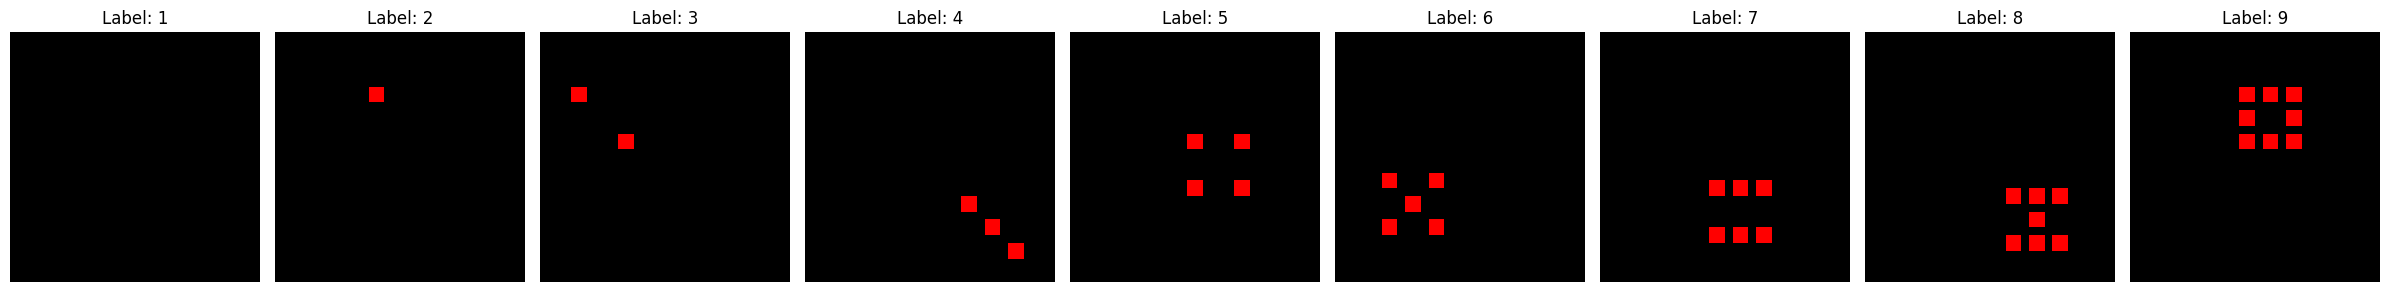

(1000, 32, 32, 3)
(1000,)
(300, 32, 32, 3)
(300,)


In [42]:
#Dataset
if Debug_dataset:
    def generate_dataset(dataset_size, window_top_left, window_bottom_right, dice_size, random_rotations=False, include_random_class=False, random_placement=False):
        dataset = np.zeros((dataset_size, 32, 32, 3), dtype=np.uint8)
        labels = np.zeros((dataset_size,), dtype=np.uint8)
        
        #rotations = [None, 90, 180, 270]
        rotations = [None, 90, 180, 270]
        if not random_rotations:
            rotations = [None]
        
        for i in range(dataset_size):
            dice_val = trained_labels[(i % len(trained_labels))]
            rot = random.choice(rotations)
            # If the random class is to be included and the current index is for the random class
            if include_random_class and dice_val == 10:
                # Create a random pixel image
                dataset[i] = np.random.randint(0, 256, (32, 32, 3), dtype=np.uint8)
                labels[i] = 10  # The label for the random class
            else:
                # Create a dice image
                dataset[i] = dice_image(value=dice_val, top_left=window_top_left, bottom_right=window_bottom_right, dice_size=dice_size, rotation_angle=rot, rand_placement=random_placement)
                labels[i] = dice_val  # Making labels 0-indexed
        
        return dataset, labels

    

    # Generate datasets
    X_train_org, Y_train_org = generate_dataset(train_size, window_top_left, window_bottom_right, dice_size, include_random_class=True, random_rotations=False, random_placement=True)
    X_test_org, Y_test_org = generate_dataset(test_size, window_top_left, window_bottom_right, dice_size, random_rotations=False, random_placement=True)

    # Display some sample images from the training set
    fig, axes = plt.subplots(1, 9, figsize=(24, 4))
    for i in range(9):
        ax = axes[i]
        ax.imshow(X_train_org[i])
        ax.axis("off")
        ax.set_title(f"Label: {Y_train_org[i]+1}")

    plt.tight_layout()
    plt.show()
    labels = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
    
else:

    #Load cifar10
    (X_train_org, Y_train_org), (X_test_org, Y_test_org) = cifar10.load_data()

    #adjust to train pool size
    X_test_org = X_test_org[0:training_pool_size]
    Y_test_org = Y_test_org.reshape(Y_test_org.shape[0])[0:training_pool_size]
    X_train_org = X_train_org[0:training_pool_size]
    Y_train_org = Y_train_org.reshape(Y_train_org.shape[0])[0:training_pool_size]

    #filter only desired labels
    X_train_org = X_train_org[np.in1d(Y_train_org, trained_labels)]
    Y_train_org = Y_train_org[np.in1d(Y_train_org, trained_labels)]

X_test_org = X_test_org[np.in1d(Y_test_org, trained_labels)]
Y_test_org = Y_test_org[np.in1d(Y_test_org, trained_labels)]

print(X_train_org.shape)
print(Y_train_org.shape)
print(X_test_org.shape)
print(Y_test_org.shape)



In [44]:
# Thermometer Coding
def thermometer_encode(image, resolution=8, prevMin=0, prevMax=255):
    # Get the shape of the input image
    shape = image.shape
    
    # Initialize the thermometer encoded image array
    encoded_image = np.empty(shape + (resolution,), dtype=np.uint8)
    
    # Perform thermometer encoding
    scale_factor = (prevMax - prevMin) / (resolution + 1)
    for z in range(resolution):
        encoded_image[..., z] = image >= prevMin + (z + 1) * scale_factor
    
    return encoded_image

def thermometer_decode(encoded_image, resolution, toMin=0, toMax=255):
    # Sum along the last dimension and scale back to the original range
    scale_factor = (toMax - toMin) / (resolution + 1)
    decoded_image = toMin + np.sum(encoded_image, axis=-1) * scale_factor
    
    # Cast the decoded image to uint8 data type
    decoded_image = decoded_image.astype(np.uint8)
    
    return decoded_image


In [45]:
def test_ThermEncodeAndDecode(original_image, thermometer_encode, thermometer_decode, resolution):
    # Encode the original image
    encoded_image = thermometer_encode(original_image, resolution)
    print(encoded_image[0])
    # Decode the encoded image back to the original form
    decoded_image = thermometer_decode(encoded_image, resolution)

    # Visualization
    plt.figure(figsize=(20, 7))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(decoded_image)
    plt.title('Decoded Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# Call the test function
#test_ThermEncodeAndDecode(np.full((32,32,3),223), thermometer_encode, thermometer_decode, 8)


In [46]:
def create_windowed_dataset(*datasets, patch_dim):
    # Ensure that there is at least one dataset provided
    if len(datasets) == 0:
        raise ValueError("At least one dataset must be provided")
    
    # Get the common shape for num_images, height, and width from the first dataset
    common_shape = datasets[0].shape[:3]
    
    # Validate the shapes of the datasets
    for dataset in datasets:
        if dataset.shape[:3] != common_shape:
            raise ValueError(f"All datasets must have the same num_images, height, and width. Expected shape: {common_shape}, but got {dataset.shape[:3]}")

    
    # Find the maximum size along the fourth dimension
    max_dim_4 = max(dataset.shape[3] for dataset in datasets)
    
    # Pad datasets to have the same size along the fourth dimension
    padded_datasets = []
    for dataset in datasets:
        pad_size = max_dim_4 - dataset.shape[3]
        if pad_size > 0:
            padding = [(0, 0) for _ in range(len(dataset.shape))]
            padding[3] = (0, pad_size)
            dataset = np.pad(dataset, padding, mode='constant', constant_values=0)
        padded_datasets.append(dataset)
    
    # Concatenate all datasets along the data dimension
    concatenated_dataset = np.concatenate(padded_datasets, axis=-1)
    
    # Calculate the shape of the windowed dataset
    num_images, height, width, *data_dims = concatenated_dataset.shape
    windowed_shape = (num_images, height - patch_dim[0] + 1, width - patch_dim[1] + 1, patch_dim[0] * patch_dim[1] * np.prod(data_dims))
    
    # Initialize the windowed dataset
    windowed_dataset = np.zeros(windowed_shape, dtype=concatenated_dataset.dtype)
    
    # Populate the windowed dataset
    for i in range(num_images):
        for y in range(height - patch_dim[0] + 1):
            for x in range(width - patch_dim[1] + 1):
                patch = concatenated_dataset[i, y:y + patch_dim[0], x:x + patch_dim[1], :]
                windowed_dataset[i, y, x, :] = patch.reshape(-1)
    
    # Get the list of dimensions of the datasets starting from the 4th shape
    dataset_dimensions = [dataset.shape[3:] for dataset in datasets]
    
    return windowed_dataset, dataset_dimensions


In [47]:
#Create windows
X_train, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_train_org), patch_dim=patch_dim)
X_test, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_test_org), patch_dim=patch_dim)

Y_train = Y_train_org
Y_test  = Y_test_org


In [48]:
#Precision and Recall log
rec_prec = np.zeros((epochs,len(trained_labels)*clauses,5), dtype=np.int32) #true pos, false pos, true neg, false neg and weight
def recall_and_precision(epoch): #test on training images and record true and false pos and negs
    #X_train and Y_train are used for recall and precision
    bank = tm.transform(X_train) # bank is a (image, clause*class) sized array
    for image in range(bank.shape[0]):
        for clause in range(bank.shape[1]-1): #number of clauses here is class*clause
            Class = ((clause)//(clauses))
            #if true_positive
            if (Y_train[image] == Class) and (bank[image][clause]):
                rec_prec[epoch,clause,0] += 1
            elif not(Y_train[image] == Class) and not(bank[image][clause]):
                rec_prec[epoch,clause,1] += 1
            elif not(Y_train[image] == Class) and (bank[image][clause]):
                rec_prec[epoch,clause,2] += 1
            elif (Y_train[image] == Class) and not(bank[image][clause]):
                rec_prec[epoch,clause,3] += 1
            else:
                print("Recall and Precision malfunction at", epoch, clause)
                
            rec_prec[epoch,clause,4] = tm.get_weight(the_class=Class,clause=clause//clauses,polarity=0).astype(np.int32)

In [49]:
#Train the TM and record results
f = open("cifar2_%.1f_%d_%d_%d_%d_%d_withoutSS Gradient.txt" % (s, clauses, T, step, visual_tokens, scaling), "w+")
logTrain = np.zeros((epochs, X_train.shape[0]), dtype=np.uint8)
logTest =  np.zeros((epochs, X_test.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        if visual_tokens:
                tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        else:
                tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(3,3), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest[epoch] = (tm.predict(X_test))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train) == Y_train).mean()
                logTrain[epoch] = (tm.predict(X_train))*label
                
                number_of_includes = 0
                for i in range(2):
                        for j in range(clauses):
                                number_of_includes += tm.number_of_include_actions(i, j)
                number_of_includes /= 2*clauses

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f %.2f" % (label, epoch, number_of_includes, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                #print("%d %d %.2f %.2f %.2f %.2f %.2f" % (label, epoch, number_of_includes, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                f.flush()
f.close()



Training:
10 labels used: [0 1 2 3 4 5 6 7 8 9]
Training pictures: 1000
Testing:
10 labels used: [0 1 2 3 4 5 6 7 8 9]
Maximum achievable accuracy: 100.0
..adjusting
Testing pictures: 300

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-24 10:22:08,679 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:14<06:49, 14.12s/it]

0 0 63.94 28.67 27.40 1.26 2.96


  7%|▋         | 2/30 [00:27<06:27, 13.83s/it]

0 1 87.05 33.67 35.00 0.52 3.08


 10%|█         | 3/30 [00:41<06:11, 13.75s/it]

0 2 92.71 38.67 39.60 0.47 3.05


 13%|█▎        | 4/30 [00:55<05:59, 13.83s/it]

0 3 111.24 27.00 25.20 0.47 3.05


 17%|█▋        | 5/30 [01:20<07:28, 17.93s/it]

0 4 117.94 30.00 36.00 0.91 5.64


 20%|██        | 6/30 [01:39<07:22, 18.43s/it]

0 5 114.04 27.00 30.00 0.88 6.01


 23%|██▎       | 7/30 [01:53<06:30, 16.98s/it]

0 6 119.00 39.33 38.80 0.44 3.14


 27%|██▋       | 8/30 [02:07<05:51, 15.98s/it]

0 7 126.29 35.67 38.50 0.43 3.12


 30%|███       | 9/30 [02:21<05:21, 15.32s/it]

0 8 125.94 47.33 49.30 0.41 3.11


 33%|███▎      | 10/30 [02:35<04:58, 14.95s/it]

0 9 129.72 32.67 34.30 0.41 3.19


 37%|███▋      | 11/30 [02:59<05:37, 17.75s/it]

0 10 131.99 49.67 53.70 0.41 4.53


 40%|████      | 12/30 [03:25<06:04, 20.23s/it]

0 11 131.36 41.67 43.40 0.82 5.78


 43%|████▎     | 13/30 [03:51<06:13, 21.98s/it]

0 12 136.56 50.67 53.20 0.83 5.96


 47%|████▋     | 14/30 [04:17<06:07, 22.99s/it]

0 13 133.32 40.67 44.90 0.81 5.72


 50%|█████     | 15/30 [04:42<05:55, 23.67s/it]

0 14 129.74 45.67 48.40 0.79 5.74


 53%|█████▎    | 16/30 [05:07<05:39, 24.22s/it]

0 15 129.43 47.00 52.90 0.78 5.77


 57%|█████▋    | 17/30 [05:33<05:21, 24.72s/it]

0 16 130.21 41.00 46.80 0.77 5.76


 60%|██████    | 18/30 [05:59<04:59, 24.99s/it]

0 17 131.36 37.00 39.60 0.78 5.92


 63%|██████▎   | 19/30 [06:24<04:36, 25.13s/it]

0 18 132.30 49.00 51.90 0.75 5.76


 67%|██████▋   | 20/30 [06:50<04:12, 25.20s/it]

0 19 131.73 48.00 51.30 0.76 5.77


 70%|███████   | 21/30 [07:15<03:47, 25.28s/it]

0 20 134.80 39.00 42.20 0.81 5.78


 73%|███████▎  | 22/30 [07:41<03:24, 25.60s/it]

0 21 134.57 36.33 40.20 0.81 6.00


 77%|███████▋  | 23/30 [08:08<03:00, 25.85s/it]

0 22 135.26 34.00 40.70 0.78 6.01


 80%|████████  | 24/30 [08:34<02:36, 26.01s/it]

0 23 136.97 53.67 54.70 0.83 6.08


 83%|████████▎ | 25/30 [09:01<02:10, 26.10s/it]

0 24 138.33 48.67 52.80 0.79 5.99


 87%|████████▋ | 26/30 [09:27<01:45, 26.29s/it]

0 25 138.84 44.33 47.50 0.79 5.96


 90%|█████████ | 27/30 [09:54<01:19, 26.41s/it]

0 26 140.66 32.00 36.30 0.81 6.08


 93%|█████████▎| 28/30 [10:21<00:52, 26.44s/it]

0 27 140.70 48.33 54.20 0.81 5.97


 97%|█████████▋| 29/30 [10:47<00:26, 26.40s/it]

0 28 139.63 51.00 51.00 0.78 5.93


100%|██████████| 30/30 [11:13<00:00, 22.45s/it]


0 29 137.08 35.33 37.60 0.78 5.97

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-24 10:33:22,103 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:26<12:49, 26.52s/it]

1 0 41.92 24.67 25.30 2.26 5.55


  7%|▋         | 2/30 [00:52<12:08, 26.01s/it]

1 1 60.71 31.67 34.60 1.15 5.75


 10%|█         | 3/30 [01:17<11:35, 25.77s/it]

1 2 79.87 34.00 40.60 1.01 5.76


 13%|█▎        | 4/30 [01:43<11:06, 25.62s/it]

1 3 90.36 34.33 39.40 0.89 5.81


 17%|█▋        | 5/30 [02:08<10:38, 25.56s/it]

1 4 97.15 40.67 43.10 0.93 5.60


 20%|██        | 6/30 [02:35<10:21, 25.90s/it]

1 5 106.30 41.00 44.50 0.89 5.98


 23%|██▎       | 7/30 [03:00<09:54, 25.84s/it]

1 6 118.98 28.00 35.10 0.87 5.72


 27%|██▋       | 8/30 [03:25<09:23, 25.61s/it]

1 7 124.00 30.33 34.70 0.86 5.67


 30%|███       | 9/30 [03:51<08:57, 25.59s/it]

1 8 124.25 50.00 51.20 0.84 5.74


 33%|███▎      | 10/30 [04:17<08:35, 25.80s/it]

1 9 123.29 53.67 55.20 0.83 5.93


 37%|███▋      | 11/30 [04:43<08:12, 25.91s/it]

1 10 130.55 39.33 43.80 0.80 5.92


 40%|████      | 12/30 [05:09<07:46, 25.90s/it]

1 11 129.15 54.33 56.30 0.82 5.83


 43%|████▎     | 13/30 [05:35<07:18, 25.80s/it]

1 12 129.82 40.33 46.60 0.81 5.91


 47%|████▋     | 14/30 [06:01<06:53, 25.85s/it]

1 13 131.81 52.00 58.10 0.80 5.92


 50%|█████     | 15/30 [06:28<06:31, 26.13s/it]

1 14 133.80 51.33 54.00 0.81 5.97


 53%|█████▎    | 16/30 [06:54<06:06, 26.20s/it]

1 15 135.60 52.00 57.00 0.79 6.01


 57%|█████▋    | 17/30 [07:20<05:39, 26.11s/it]

1 16 139.11 46.33 53.20 0.73 5.96


 60%|██████    | 18/30 [07:46<05:12, 26.00s/it]

1 17 138.49 54.00 60.90 0.79 5.81


 63%|██████▎   | 19/30 [08:12<04:46, 26.09s/it]

1 18 142.41 53.00 55.30 0.79 5.94


 67%|██████▋   | 20/30 [08:39<04:23, 26.31s/it]

1 19 142.92 52.67 57.40 0.81 6.07


 70%|███████   | 21/30 [09:05<03:56, 26.24s/it]

1 20 143.30 52.33 60.00 0.79 5.85


 73%|███████▎  | 22/30 [09:31<03:29, 26.13s/it]

1 21 144.17 50.00 54.30 0.76 5.94


 77%|███████▋  | 23/30 [09:57<03:02, 26.06s/it]

1 22 144.92 40.33 48.20 0.74 5.92


 80%|████████  | 24/30 [10:23<02:36, 26.14s/it]

1 23 147.22 50.33 59.00 0.76 5.92


 83%|████████▎ | 25/30 [10:49<02:11, 26.26s/it]

1 24 148.77 52.33 55.60 0.81 5.97


 87%|████████▋ | 26/30 [11:16<01:44, 26.22s/it]

1 25 150.63 36.00 38.70 0.77 5.96


 90%|█████████ | 27/30 [11:42<01:18, 26.16s/it]

1 26 152.40 49.33 54.90 0.76 5.88


 93%|█████████▎| 28/30 [12:08<00:52, 26.14s/it]

1 27 152.53 37.67 48.70 0.76 5.89


 97%|█████████▋| 29/30 [12:34<00:26, 26.26s/it]

1 28 150.21 51.67 57.00 0.77 6.03


100%|██████████| 30/30 [13:00<00:00, 26.02s/it]


1 29 149.37 41.00 47.10 0.76 6.07

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-24 10:46:22,906 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:25<12:32, 25.93s/it]

2 0 77.25 24.67 24.40 2.34 5.37


  7%|▋         | 2/30 [00:50<11:48, 25.31s/it]

2 1 107.75 36.33 36.60 1.13 5.63


 10%|█         | 3/30 [01:18<11:48, 26.24s/it]

2 2 115.22 38.33 42.30 1.32 5.93


 13%|█▎        | 4/30 [01:44<11:27, 26.42s/it]

2 3 127.77 34.33 37.10 1.00 5.94


 17%|█▋        | 5/30 [02:11<10:58, 26.33s/it]

2 4 121.11 26.33 26.80 0.93 5.72


 20%|██        | 6/30 [02:36<10:28, 26.19s/it]

2 5 132.65 45.33 52.30 0.86 5.68


 23%|██▎       | 7/30 [03:03<10:04, 26.26s/it]

2 6 137.51 43.00 46.60 0.84 5.81


 27%|██▋       | 8/30 [03:30<09:42, 26.47s/it]

2 7 138.46 47.33 49.30 0.84 5.92


 30%|███       | 9/30 [03:56<09:17, 26.55s/it]

2 8 141.52 44.67 45.10 0.82 5.90


 33%|███▎      | 10/30 [04:24<08:55, 26.76s/it]

2 9 141.87 41.00 44.20 0.84 6.03


 37%|███▋      | 11/30 [04:49<08:22, 26.45s/it]

2 10 140.09 42.33 44.10 0.78 5.79


 40%|████      | 12/30 [05:15<07:52, 26.27s/it]

2 11 134.69 43.33 47.10 0.81 5.82


 43%|████▎     | 13/30 [05:41<07:25, 26.23s/it]

2 12 134.89 42.33 51.10 0.83 5.89


 47%|████▋     | 14/30 [06:07<06:58, 26.17s/it]

2 13 140.54 39.33 46.60 0.81 5.90


 50%|█████     | 15/30 [06:33<06:30, 26.04s/it]

2 14 143.18 44.33 47.40 0.81 5.88


 53%|█████▎    | 16/30 [06:59<06:02, 25.87s/it]

2 15 144.90 47.00 52.90 0.80 5.81


 57%|█████▋    | 17/30 [07:25<05:37, 25.96s/it]

2 16 145.73 39.33 44.50 0.77 5.95


 60%|██████    | 18/30 [07:51<05:12, 26.08s/it]

2 17 149.52 47.33 48.20 0.79 5.95


 63%|██████▎   | 19/30 [08:17<04:46, 26.06s/it]

2 18 150.37 43.67 48.50 0.83 6.02


 67%|██████▋   | 20/30 [08:43<04:20, 26.02s/it]

2 19 148.14 44.00 43.20 0.77 5.95


 70%|███████   | 21/30 [09:10<03:55, 26.14s/it]

2 20 149.14 48.67 57.10 0.79 5.89


 73%|███████▎  | 22/30 [09:36<03:30, 26.26s/it]

2 21 150.16 49.33 52.80 0.82 6.02


 77%|███████▋  | 23/30 [10:02<03:03, 26.25s/it]

2 22 151.01 47.00 52.80 0.76 5.96


 80%|████████  | 24/30 [10:28<02:37, 26.17s/it]

2 23 149.65 43.00 44.20 0.76 5.97


 83%|████████▎ | 25/30 [10:54<02:10, 26.13s/it]

2 24 154.07 49.33 49.80 0.76 5.92


 87%|████████▋ | 26/30 [11:21<01:45, 26.28s/it]

2 25 153.72 46.67 48.10 0.80 6.10


 90%|█████████ | 27/30 [11:47<01:18, 26.23s/it]

2 26 153.07 43.33 48.40 0.75 5.95


 93%|█████████▎| 28/30 [12:13<00:52, 26.20s/it]

2 27 152.99 51.67 58.40 0.82 5.97


 97%|█████████▋| 29/30 [12:33<00:24, 24.40s/it]

2 28 151.90 46.33 44.70 0.76 6.01


100%|██████████| 30/30 [12:48<00:00, 25.60s/it]


2 29 152.96 44.33 48.00 0.39 3.19

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-24 10:59:11,084 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:14<06:50, 14.14s/it]

3 0 68.51 26.67 26.90 1.23 3.00


  7%|▋         | 2/30 [00:35<08:29, 18.21s/it]

3 1 83.71 28.33 30.60 0.53 3.05


 10%|█         | 3/30 [01:00<09:44, 21.66s/it]

3 2 100.89 35.67 37.80 0.94 5.95


 13%|█▎        | 4/30 [01:26<10:01, 23.12s/it]

3 3 111.59 33.00 41.20 0.95 5.77


 17%|█▋        | 5/30 [01:49<09:38, 23.16s/it]

3 4 115.87 39.33 44.60 0.91 5.63


 20%|██        | 6/30 [02:11<09:05, 22.74s/it]

3 5 120.57 36.00 37.60 0.45 3.09


 23%|██▎       | 7/30 [02:37<09:07, 23.81s/it]

3 6 120.11 41.33 44.90 0.84 5.85


 27%|██▋       | 8/30 [03:02<08:54, 24.29s/it]

3 7 122.69 42.67 50.50 0.85 5.87


 30%|███       | 9/30 [03:28<08:35, 24.57s/it]

3 8 127.21 40.33 44.20 0.84 5.68


 33%|███▎      | 10/30 [03:53<08:16, 24.83s/it]

3 9 132.83 52.33 56.40 0.81 5.80


 37%|███▋      | 11/30 [04:18<07:55, 25.02s/it]

3 10 132.08 46.67 46.70 0.83 5.77


 40%|████      | 12/30 [04:44<07:34, 25.23s/it]

3 11 130.18 58.00 59.60 0.79 5.89


 43%|████▎     | 13/30 [05:09<07:09, 25.24s/it]

3 12 133.05 48.00 53.90 0.86 5.73


 47%|████▋     | 14/30 [05:34<06:43, 25.20s/it]

3 13 132.91 37.33 45.40 0.78 5.69


 50%|█████     | 15/30 [06:00<06:17, 25.20s/it]

3 14 131.36 40.33 44.10 0.80 5.71


 53%|█████▎    | 16/30 [06:25<05:54, 25.33s/it]

3 15 131.05 43.67 50.00 0.78 5.72


 57%|█████▋    | 17/30 [06:51<05:30, 25.46s/it]

3 16 131.55 30.33 31.60 0.80 5.87


 60%|██████    | 18/30 [07:17<05:05, 25.48s/it]

3 17 132.35 46.00 50.20 0.76 5.80


 63%|██████▎   | 19/30 [07:42<04:40, 25.50s/it]

3 18 136.19 56.33 58.60 0.81 5.75


 67%|██████▋   | 20/30 [08:08<04:16, 25.63s/it]

3 19 135.64 47.67 50.90 0.77 5.89


 70%|███████   | 21/30 [08:34<03:52, 25.84s/it]

3 20 136.87 43.00 47.90 0.77 5.89


 73%|███████▎  | 22/30 [09:00<03:27, 25.91s/it]

3 21 138.31 51.00 57.00 0.75 6.02


 77%|███████▋  | 23/30 [09:26<02:59, 25.69s/it]

3 22 136.70 54.00 58.00 0.76 5.69


 80%|████████  | 24/30 [09:40<02:13, 22.23s/it]

3 23 139.48 49.33 53.00 0.39 3.18


 83%|████████▎ | 25/30 [10:02<01:51, 22.21s/it]

3 24 141.66 64.00 67.90 0.37 3.15


 87%|████████▋ | 26/30 [10:28<01:33, 23.32s/it]

3 25 145.11 35.00 43.70 0.75 5.81


 90%|█████████ | 27/30 [10:54<01:12, 24.08s/it]

3 26 142.98 45.00 52.50 0.82 5.98


 93%|█████████▎| 28/30 [11:19<00:48, 24.45s/it]

3 27 141.87 56.00 58.60 0.73 5.76


 97%|█████████▋| 29/30 [11:44<00:24, 24.71s/it]

3 28 141.51 57.33 59.70 0.75 5.80


100%|██████████| 30/30 [12:10<00:00, 24.35s/it]


3 29 144.29 56.00 61.50 0.75 5.80

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-24 11:11:21,493 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:26<12:38, 26.15s/it]

4 0 80.29 29.67 28.80 2.17 5.56


  7%|▋         | 2/30 [00:51<11:52, 25.45s/it]

4 1 95.37 33.67 34.40 1.06 5.65


 10%|█         | 3/30 [01:15<11:19, 25.15s/it]

4 2 102.91 38.33 40.10 0.93 5.59


 13%|█▎        | 4/30 [01:40<10:50, 25.03s/it]

4 3 114.07 40.67 42.50 0.87 5.62


 17%|█▋        | 5/30 [02:05<10:27, 25.10s/it]

4 4 109.82 37.33 41.80 0.84 5.64


 20%|██        | 6/30 [02:31<10:07, 25.32s/it]

4 5 113.72 48.67 51.50 0.89 5.76


 23%|██▎       | 7/30 [02:57<09:42, 25.31s/it]

4 6 118.54 52.67 53.80 0.84 5.69


 27%|██▋       | 8/30 [03:22<09:16, 25.28s/it]

4 7 126.45 37.67 42.80 0.82 5.66


 30%|███       | 9/30 [03:47<08:51, 25.30s/it]

4 8 132.76 41.33 45.60 0.82 5.78


 33%|███▎      | 10/30 [04:08<07:59, 23.95s/it]

4 9 131.60 54.00 57.90 0.80 6.20


 37%|███▋      | 11/30 [04:22<06:38, 20.95s/it]

4 10 133.04 57.33 59.80 0.43 3.19


 40%|████      | 12/30 [04:36<05:38, 18.83s/it]

4 11 132.53 57.00 59.40 0.41 3.15


 43%|████▎     | 13/30 [04:50<04:55, 17.37s/it]

4 12 129.13 42.67 46.30 0.40 3.14


 47%|████▋     | 14/30 [05:16<05:16, 19.80s/it]

4 13 128.84 53.67 60.50 0.80 5.81


 50%|█████     | 15/30 [05:41<05:21, 21.46s/it]

4 14 131.30 55.00 59.40 0.78 5.71


 53%|█████▎    | 16/30 [06:07<05:18, 22.73s/it]

4 15 132.87 60.33 62.90 0.77 5.76


 57%|█████▋    | 17/30 [06:33<05:08, 23.76s/it]

4 16 128.76 54.33 58.00 0.78 5.92


 60%|██████    | 18/30 [06:51<04:25, 22.13s/it]

4 17 131.06 45.67 48.50 0.84 5.98


 63%|██████▎   | 19/30 [07:05<03:37, 19.74s/it]

4 18 131.97 53.00 55.50 0.39 3.21


 67%|██████▋   | 20/30 [07:22<03:08, 18.83s/it]

4 19 131.80 40.00 44.40 0.39 3.17


 70%|███████   | 21/30 [07:47<03:07, 20.84s/it]

4 20 131.37 42.67 47.90 0.77 5.77


 73%|███████▎  | 22/30 [08:14<02:59, 22.43s/it]

4 21 134.78 52.33 56.80 0.76 5.86


 77%|███████▋  | 23/30 [08:40<02:44, 23.54s/it]

4 22 135.14 50.67 54.00 0.79 5.99


 80%|████████  | 24/30 [09:05<02:24, 24.13s/it]

4 23 135.63 41.33 43.10 0.76 5.79


 83%|████████▎ | 25/30 [09:31<02:02, 24.54s/it]

4 24 134.33 53.00 58.90 0.76 5.82


 87%|████████▋ | 26/30 [09:57<01:40, 25.01s/it]

4 25 134.55 39.67 42.40 0.74 5.91


 90%|█████████ | 27/30 [10:14<01:08, 22.70s/it]

4 26 134.80 50.67 57.70 0.79 3.74


 93%|█████████▎| 28/30 [10:40<00:47, 23.67s/it]

4 27 135.02 46.67 51.20 0.77 5.97


 97%|█████████▋| 29/30 [11:06<00:24, 24.42s/it]

4 28 134.52 56.00 57.70 0.73 5.90


100%|██████████| 30/30 [11:32<00:00, 23.08s/it]


4 29 135.75 60.33 63.20 0.76 5.89

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-24 11:22:53,857 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:25<12:15, 25.36s/it]

5 0 73.23 22.67 21.90 2.24 5.31


  7%|▋         | 2/30 [00:50<11:48, 25.31s/it]

5 1 99.60 21.00 19.70 1.09 5.54


 10%|█         | 3/30 [01:15<11:19, 25.16s/it]

5 2 107.96 24.00 22.80 0.97 5.77


 13%|█▎        | 4/30 [01:40<10:53, 25.13s/it]

5 3 117.72 42.67 41.30 0.87 5.70


 17%|█▋        | 5/30 [02:05<10:27, 25.11s/it]

5 4 122.69 38.00 42.60 0.87 5.69


 20%|██        | 6/30 [02:31<10:06, 25.26s/it]

5 5 132.02 38.67 41.40 0.90 5.70


 23%|██▎       | 7/30 [02:57<09:48, 25.57s/it]

5 6 135.72 49.33 49.20 0.83 5.92


 27%|██▋       | 8/30 [03:22<09:21, 25.52s/it]

5 7 139.59 44.33 48.00 0.84 5.77


 30%|███       | 9/30 [03:48<08:55, 25.50s/it]

5 8 138.69 47.33 49.80 0.83 5.81


 33%|███▎      | 10/30 [04:14<08:31, 25.56s/it]

5 9 150.41 39.67 43.30 0.80 5.85


 37%|███▋      | 11/30 [04:40<08:09, 25.74s/it]

5 10 148.98 43.67 46.00 0.90 5.85


 40%|████      | 12/30 [05:06<07:44, 25.79s/it]

5 11 147.15 41.67 43.30 0.82 5.87


 43%|████▎     | 13/30 [05:26<06:48, 24.03s/it]

5 12 145.15 49.33 50.20 0.79 5.79


 47%|████▋     | 14/30 [05:40<05:36, 21.06s/it]

5 13 144.65 46.00 49.00 0.40 3.20


 50%|█████     | 15/30 [05:54<04:44, 18.98s/it]

5 14 142.27 55.67 59.10 0.41 3.20


 53%|█████▎    | 16/30 [06:08<04:05, 17.50s/it]

5 15 143.00 58.67 56.20 0.41 3.17


 57%|█████▋    | 17/30 [06:22<03:35, 16.54s/it]

5 16 145.25 49.67 53.10 0.39 3.24


 60%|██████    | 18/30 [06:37<03:10, 15.84s/it]

5 17 143.05 49.33 55.20 0.39 3.18


 63%|██████▎   | 19/30 [06:51<02:49, 15.37s/it]

5 18 144.21 50.67 56.20 0.39 3.21


 67%|██████▋   | 20/30 [07:05<02:30, 15.02s/it]

5 19 141.02 45.00 45.60 0.40 3.21


 70%|███████   | 21/30 [07:19<02:13, 14.78s/it]

5 20 144.26 58.00 62.20 0.39 3.20


 73%|███████▎  | 22/30 [07:34<01:57, 14.63s/it]

5 21 145.94 54.00 56.70 0.40 3.23


 77%|███████▋  | 23/30 [07:48<01:41, 14.52s/it]

5 22 145.86 43.00 50.40 0.39 3.22


 80%|████████  | 24/30 [08:02<01:26, 14.40s/it]

5 23 147.01 48.33 49.00 0.40 3.19


 83%|████████▎ | 25/30 [08:16<01:11, 14.37s/it]

5 24 146.81 60.00 59.80 0.42 3.19


 87%|████████▋ | 26/30 [08:30<00:57, 14.34s/it]

5 25 147.76 47.67 50.60 0.40 3.22


 90%|█████████ | 27/30 [08:45<00:42, 14.28s/it]

C:\Users\vhale\AppData\Local\Temp\ipykernel_5172\3588280450.py:11: RuntimeWarning: invalid value encountered in divide
  recall = rec_prec[epoch, :, 0] / (rec_prec[epoch, :, 0] + rec_prec[epoch, :, 3])
C:\Users\vhale\AppData\Local\Temp\ipykernel_5172\3588280450.py:12: RuntimeWarning: invalid value encountered in divide
  precision = rec_prec[epoch, :, 0] / (rec_prec[epoch, :, 0] + rec_prec[epoch, :, 1])
C:\Users\vhale\AppData\Local\Temp\ipykernel_5172\3588280450.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[epoch].scatter(recall, precision, s=weight*50, cmap='Blues', label='Recall', marker='o')


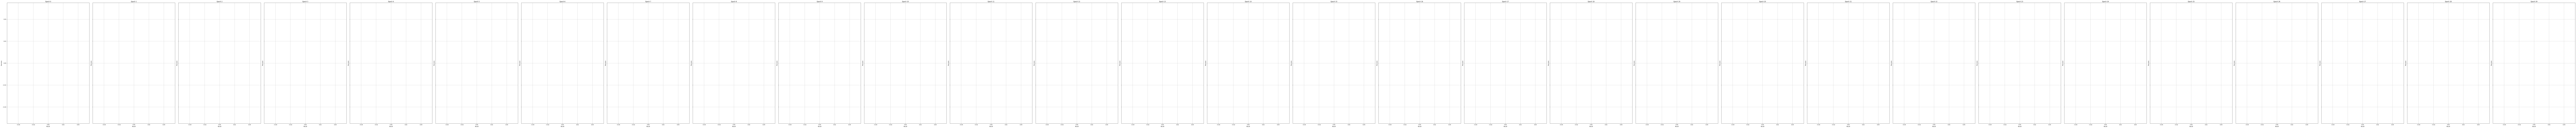

In [ ]:
#true pos, false pos, true neg, false neg and weight

# Create a table of graphs with scatter plots for each epoch
num_points = clauses

# Loop through each epoch to create the graphs
fig, axs = plt.subplots(1, epochs, figsize=(10*epochs, 15), sharey=True)
fig.set_facecolor('white')

for epoch in range(epochs):
    recall = rec_prec[epoch, :, 0] / (rec_prec[epoch, :, 0] + rec_prec[epoch, :, 3])
    precision = rec_prec[epoch, :, 0] / (rec_prec[epoch, :, 0] + rec_prec[epoch, :, 1])
    x = rec_prec[epoch, :, 4]
    weight = rec_prec[epoch, :, -1]
    
    how_true = rec_prec[epoch, :, 0] + rec_prec[epoch, :, 2]
    how_fake = rec_prec[epoch, :, 1] + rec_prec[epoch, :, 3]

    # Create the scatter plot for the epoch
    axs[epoch].scatter(recall, precision, s=weight*50, cmap='Blues', label='Recall', marker='o')
    axs[epoch].set_title(f'Epoch {epoch}')
    axs[epoch].set_xlabel('Recall')
    axs[epoch].set_ylabel('Precision')
    axs[epoch].grid(True)
plt.tight_layout()
plt.show()


2023-11-22 18:24:50,202 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001B411B2F990>


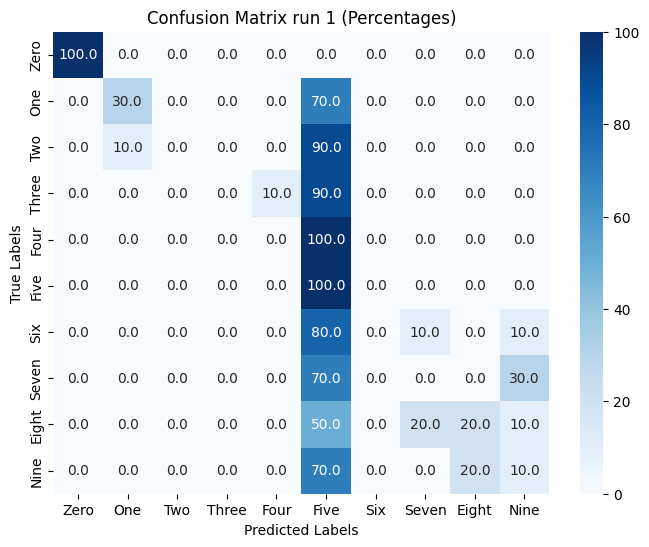

In [ ]:
#Confusion Matrix
conf_matrix = confusion_matrix(Y_test, tm.predict(X_test))
# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percent = np.nan_to_num(conf_matrix_percent, 0)  # Replace NaNs with 0

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 1 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
#Plot Clause distribution
clause_appearances = np.zeros((tm.number_of_classes*tm.number_of_clauses))
clause_uniqueness = np.zeros(tm.number_of_clauses)
bank = tm.transform(X_train) # bank is a (image, clause*class) sized array
for image in range(bank.shape[0]):
    for clause in range(bank.shape[1]): #number of clauses here is class*clause
        Class = ((clause)//(clauses))
        if (Y_train[image] == Class) and (bank[image][clause]):
            clause_uniqueness[int(clause/tm.number_of_classes)] += 1
        else:
            clause_uniqueness[int(clause/tm.number_of_classes)] -= 1
        if bank[image][clause]: #note the appearances of clauses in image per class
            clause_appearances[int(clause/tm.number_of_classes)] +=1
            
print(tm.number_of_clauses)
print(tm.number_of_classes)
auxK = 0

10
10


' \nfor label in trained_labels:\n    print("label", labels[label], "has", np.count_nonzero(Y_train==label), "images")\n    auxK += np.count_nonzero(Y_train==label)\nprint("total images:", auxK)\n\nprint("clause_uniqueness.shape", clause_uniqueness.shape)\nprint("sort highest", np.sort(clause_uniqueness[:1500])[-15:].astype(int))\nprint("sort lowest", np.sort(clause_uniqueness[:])[:15].astype(int))\n\nplt.hist(clause_uniqueness, bins=100) \nplt.xlabel(\'Uniqueness (-1 wrong class +1 right class)\')\nplt.ylabel(\'Appearances\')\nplt.title(\'Distinctive clauses distribution\')\nplt.show() '

In [ ]:
#Patch object
from matplotlib.gridspec import GridSpec

class Patch:
    def __init__(self, xMin, xMax, yMin, yMax, ID, patch_info, raw, weight=None):
        self.xMin = xMin
        self.xMax = xMax
        self.yMin = yMin
        self.yMax = yMax
        self.weight = weight
        self.ID = ID
        self.patch_info = patch_info
        self.raw = raw
        self.found_in_images = {}
        self.total_count = 0
        self.sparsity = 0
            
    def visualize_patch_info(self, polarity=0):
        # Rescale the channel values to the range of 0-255
        patch_info_scaled = (np.array(self.patch_info) * (255 / resolution)).astype(np.uint8)
        
        # Create an empty image canvas
        image = np.zeros((3, 3, 3), dtype=np.uint8)
        # Loop through each channel
        for c in range(3):
            image[:,:,c] = patch_info_scaled[:,:,c, polarity].reshape((3,3))
        
        return image
    def dominant_color(self, value=0):
        # Reshape the patch to a 9x3 array
        pixels = self.patch_info[...,0].reshape((9, 3))

        # Calculate the sum of color values for each channel
        color_sums = np.sum(pixels, axis=0)

        # Find the index of the channel with the highest sum
        dominant_channel = np.argmax(color_sums)

        # Determine the dominant color based on the channel index
        if dominant_channel == 0:
            dominant_color = 'R'
        elif dominant_channel == 1:
            dominant_color = 'G'
        else:
            dominant_color = 'B'
        
        if value == 1:
            return dominant_channel
        elif value == 2:
            return sum(self.patch_info[:,:,dominant_channel]) // 3
        else:
            return dominant_color
        
    def update_patch(self, image_id, location):
        print("SAD")
        if image_id in self.found_in_images:
            self.found_in_images[image_id].append(location)
        else:
            self.found_in_images[image_id] = [location]
        self.total_count += 1
        


def thermometer_to_integer(thermometer_bits, negated = 0):
    value = 0
    thermometer_bits_local = thermometer_bits
    length = len(thermometer_bits_local)
    for bit in range(length):
        if not negated:
            if thermometer_bits_local[bit]:
                value = bit+1
        else:
            if thermometer_bits_local[bit]:
                value = bit
                break
            value = length+1
    return value

bank = tm.transform(X_train) # bank is a (image, clause*class) sized array

def translate_block_of_bits(block, ID, resolution=8, patch_dim=(3,3), image_size=X_train_org.shape[1:3]):
    auxK = 0
    auxJ = image_size[0] - patch_dim[0] -1
    xMin = thermometer_to_integer(block[auxK:auxJ], negated=0)
    auxK = image_size[0] - patch_dim[0]
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
    yMin = thermometer_to_integer(block[auxK:auxJ], negated=0)
    auxK = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] -1
    xMax = thermometer_to_integer(block[auxK:auxJ], negated=1)
    auxK = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0]
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
    yMax = thermometer_to_integer(block[auxK:auxJ], negated=1)
    
    
    patch_info = np.zeros((3,3,3,2)) #sort out the pixels
    for column in range(3):
        # rows = []
        for row in range(3):
            # colors = []
            for color in range(3):
                start_bit = 58 + (column+row) * 24 + color * resolution
                end_bit = start_bit + resolution
                value = thermometer_to_integer(block[start_bit:end_bit])*(255/resolution)
                
                start_bit2 = 332 + (column+row) * 24 + color * resolution
                end_bit2 = start_bit2 + resolution
                value2 = thermometer_to_integer(block[start_bit2:end_bit2], negated=1)*(255/resolution)
                #value = (value + value2)/2
                #if value == 0: # turn the pixel white if empty
                #    value = 8
                patch_info[column,row,color,0] = value
                patch_info[column,row,color,1] = value2
                # colors.append(value)
            # rows.append(colors)
        # patch_info.append(rows)
    raw = block
    weight = 0
    ID = ID
    return Patch(xMin=xMin, xMax=xMax, yMin=yMin, yMax=yMax, weight=weight, ID=ID, patch_info=patch_info, raw=raw)



Highlighting for image 3 of class Three
Class 0 Zero
Pro clauses for Class 0: [0, 1, 2, 4]
Against clauses for Class 0: [6, 7, 8, 9]


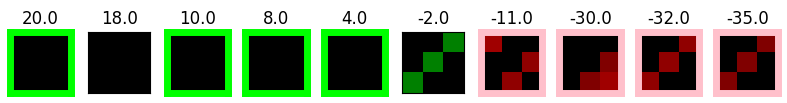

Class 1 One
Pro clauses for Class 1: [0, 1, 2, 4, 10, 11, 12, 13, 14]
Against clauses for Class 1: [6, 7, 8, 9, 15, 16, 19]


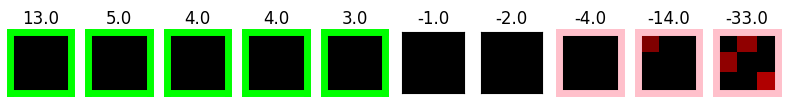

Class 2 Two
Pro clauses for Class 2: [0, 1, 2, 4, 10, 11, 12, 13, 14, 21]
Against clauses for Class 2: [6, 7, 8, 9, 15, 16, 19, 26, 27, 28, 29]


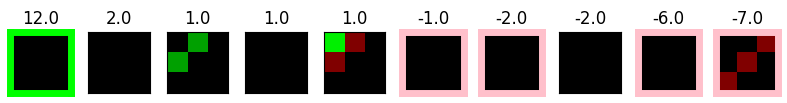

Class 3 Three
Pro clauses for Class 3: [0, 1, 2, 4, 10, 11, 12, 13, 14, 21, 31, 34]
Against clauses for Class 3: [6, 7, 8, 9, 15, 16, 19, 26, 27, 28, 29, 36, 37, 39]


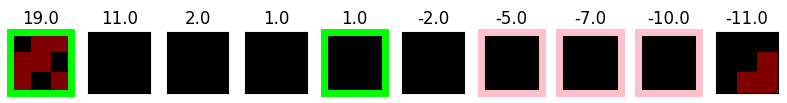

Class 4 Four
Pro clauses for Class 4: [0, 1, 2, 4, 10, 11, 12, 13, 14, 21, 31, 34, 40, 41, 42, 43, 44]
Against clauses for Class 4: [6, 7, 8, 9, 15, 16, 19, 26, 27, 28, 29, 36, 37, 39, 45, 46, 48, 49]


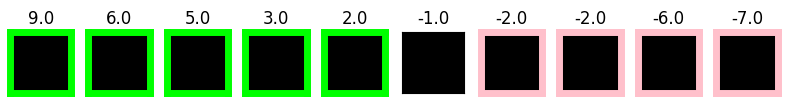

Class 5 Five
Pro clauses for Class 5: [0, 1, 2, 4, 10, 11, 12, 13, 14, 21, 31, 34, 40, 41, 42, 43, 44, 51, 52, 53]
Against clauses for Class 5: [6, 7, 8, 9, 15, 16, 19, 26, 27, 28, 29, 36, 37, 39, 45, 46, 48, 49]


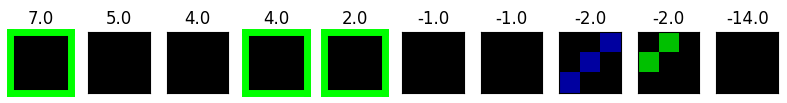

Class 6 Six
Pro clauses for Class 6: [0, 1, 2, 4, 10, 11, 12, 13, 14, 21, 31, 34, 40, 41, 42, 43, 44, 51, 52, 53, 60, 61, 63, 64]
Against clauses for Class 6: [6, 7, 8, 9, 15, 16, 19, 26, 27, 28, 29, 36, 37, 39, 45, 46, 48, 49, 67, 68, 69]


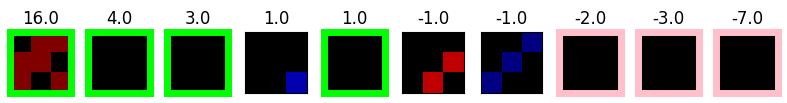

Class 7 Seven
Pro clauses for Class 7: [0, 1, 2, 4, 10, 11, 12, 13, 14, 21, 31, 34, 40, 41, 42, 43, 44, 51, 52, 53, 60, 61, 63, 64, 72, 74]
Against clauses for Class 7: [6, 7, 8, 9, 15, 16, 19, 26, 27, 28, 29, 36, 37, 39, 45, 46, 48, 49, 67, 68, 69, 75, 76, 77, 78, 79]


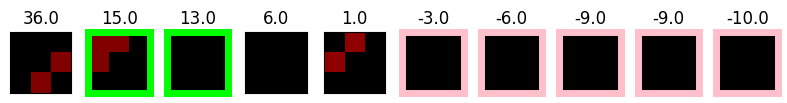

Class 8 Eight
Pro clauses for Class 8: [0, 1, 2, 4, 10, 11, 12, 13, 14, 21, 31, 34, 40, 41, 42, 43, 44, 51, 52, 53, 60, 61, 63, 64, 72, 74, 83, 84]
Against clauses for Class 8: [6, 7, 8, 9, 15, 16, 19, 26, 27, 28, 29, 36, 37, 39, 45, 46, 48, 49, 67, 68, 69, 75, 76, 77, 78, 79, 85, 87, 88]


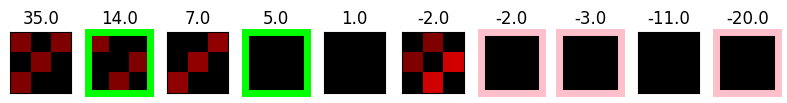

Class 9 Nine
Pro clauses for Class 9: [0, 1, 2, 4, 10, 11, 12, 13, 14, 21, 31, 34, 40, 41, 42, 43, 44, 51, 52, 53, 60, 61, 63, 64, 72, 74, 83, 84, 92]
Against clauses for Class 9: [6, 7, 8, 9, 15, 16, 19, 26, 27, 28, 29, 36, 37, 39, 45, 46, 48, 49, 67, 68, 69, 75, 76, 77, 78, 79, 85, 87, 88, 95, 96, 97, 98, 99]


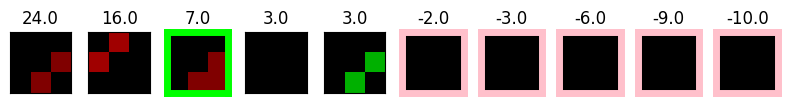

In [ ]:
#Weighted Patches list

#show how many patches
n_extreme_patches = 5
highlight_colors = {
    "for": "lime",
    "against": "pink"
}

highlight = True
check_image = 3

print("Highlighting for image", check_image, "of class", labels[Y_train_org[check_image]])

pro_clauses = []
against_clauses = []
all_patches = [] #class, clause

# Populate the patches list
k=0 # ID
for Class in range(tm.number_of_classes):
    class_patches = []
    for Clause in range(tm.number_of_clauses):
        block = [tm.get_ta_action(Clause, bit, Class) for bit in range(576)]
        class_patches.append(translate_block_of_bits(block, k))
        k += 1
    all_patches.append(class_patches)

# Select top clauses
highest_indices = np.zeros((tm.number_of_classes, n_extreme_patches))
lowest_indices  = np.zeros((tm.number_of_classes, n_extreme_patches))
weights_sorted_indices = np.zeros((tm.number_of_classes, tm.number_of_clauses))
all_weights = np.zeros((tm.number_of_classes, tm.number_of_clauses))

for Class in range(tm.number_of_classes):
    for clause in range(tm.number_of_clauses):
        all_weights[Class, clause] = (tm.get_weight(the_class=Class,clause=clause,polarity=0))
    weights_sorted_indices[Class] = all_weights[Class].argsort()
    highest_indices[Class] = weights_sorted_indices[Class][-n_extreme_patches:].astype(int)
    lowest_indices[Class]  = weights_sorted_indices[Class][:n_extreme_patches].astype(int)

# Assign lowest and highest weighted patches to the indices  
extreme_patches = np.zeros((tm.number_of_classes,2,n_extreme_patches), dtype=Patch)
extreme_weights = np.zeros((tm.number_of_classes,2,n_extreme_patches), dtype=np.int16)
    
for Class in range(tm.number_of_classes):
    print("Class", Class, labels[Class])
    polarity = 0
    for i, k in enumerate(lowest_indices[Class].astype(int)):
        all_patches[Class][np.min((k, 997))].weight = all_weights[Class][np.min((k, 997))]
        extreme_patches[Class, polarity, i] = all_patches[Class][np.min((k, 997))]
        
    polarity = 1
    for i, k in enumerate(highest_indices[Class].astype(int)):
        all_patches[Class][k].weight = all_weights[Class][k]
        extreme_patches[Class, polarity, i] = all_patches[Class][k]


    extreme_patches = np.flip(extreme_patches,2)
    extreme_weights = np.flip(extreme_weights,2)
    
    # Assign Pro and Against clauses per class
    for clause in range(int(tm.number_of_clauses/2)):  # First half for pro_clauses
        if bank[check_image][clause + Class * tm.number_of_clauses]:  # If the clause is activated
            pro_clauses.append(clause + Class * tm.number_of_clauses)
    for clause in range(int(tm.number_of_clauses/2), tm.number_of_clauses):  # Second half for against_clauses
        if bank[check_image][clause + Class * tm.number_of_clauses]:  # If the clause is activated
            against_clauses.append(clause + Class * tm.number_of_clauses)
    print(f"Pro clauses for Class {Class}: {pro_clauses}")
    print(f"Against clauses for Class {Class}: {against_clauses}")



    #Print patches grid
    num_rows = 10
    num_cols = 10

    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(num_rows, num_cols)
    adjusted_index = 0
    for patch_index in range(0, n_extreme_patches*2):
        if (patch_index >= n_extreme_patches): 
            polarity = 0
            adjusted_index = patch_index - n_extreme_patches
        else:
            adjusted_index = patch_index
            polarity = 1
        ax = fig.add_subplot(gs[patch_index // num_cols, patch_index % num_cols])
        ax.imshow(extreme_patches[Class, polarity, adjusted_index].visualize_patch_info())
        
        if highlight:
            # Highlight the randomly selected patches
            if polarity == 1 and extreme_patches[Class, polarity, adjusted_index].ID in pro_clauses:
                for spine in ax.spines.values():
                    spine.set_edgecolor(highlight_colors["for"])
                    spine.set_linewidth(5)
            elif polarity == 0 and extreme_patches[Class, polarity, adjusted_index].ID in against_clauses:
                for spine in ax.spines.values():
                    spine.set_edgecolor(highlight_colors["against"])
                    spine.set_linewidth(5)
            
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
        ax.set_title((extreme_weights[Class][polarity][adjusted_index]).astype(str) + " " + (extreme_patches[Class, polarity, adjusted_index]).dominant_color())
        ax.set_title(extreme_patches[Class, polarity, adjusted_index].weight.astype(str))

    
    plt.tight_layout()
    plt.show()

In [ ]:
import math 
def find_patches_in_image(image, patches_to_search, targeted_search=False, avg=True):
    """
    Search for specific patches within a given image. Return found ID and coordinates.
    
    Parameters:
    - image: 2D array representing the image.
    - patches_to_search: List of Patch objects to search for in the image.
    - targeted_search: Boolean indicating whether to search only within the patch's expected coordinates.
    - avg: Boolean indicating whether to return average coordinates for each patch.
    
    Returns:
    - results: Array with shape (number of patches, 3) containing the patch ID and its (average) x and y coordinates.
    - found_coordinates: List of tuples containing the coordinates where patches were found.
    """
    results = []
    for patch in patches_to_search:
        patch_info = patch.patch_info
        
        # Define the search area based on the targeted_search flag
        if targeted_search:
            search_area = image[patch.xMin:patch.xMax, patch.yMin:patch.yMax]
            offset_x, offset_y = patch.xMin, patch.yMin
        else:
            search_area = image
            offset_x, offset_y = 0, 0
        
        found_coordinates = []
        for x in range(search_area.shape[0] - patch_info.shape[0] + 1):
            for y in range(search_area.shape[1] - patch_info.shape[1] + 1):
                region = search_area[x:x+patch_info.shape[0], y:y+patch_info.shape[1]]
                if np.all(region >= patch_info[...,0]) and np.all(region <= patch_info[...,1]):
                    found_coordinates.append((x + offset_x, y + offset_y))
        
        # Calculate average coordinates if required
        if avg and found_coordinates:
            avg_x = int(np.mean([coord[0] for coord in found_coordinates]))
            avg_y = int(np.mean([coord[1] for coord in found_coordinates]))
            results.append((patch.ID, avg_x, avg_y))
        elif not avg:
            results.append((patch.ID, found_coordinates))
    
    return results


""" 
def find_patches_in_images(images, labels, patches_to_find, targeted_search=False, avg=False):
    
    results = []
    
    for i in range(patches_to_find.shape[0]):
        print(i)
        k = find_patches_in_image(images[i], patches_to_find[labels[i], 0, :], targeted_search=targeted_search, avg=avg)
        results.append(k)
        patches_to_find[labels[i], 0, :].update_patch(i,k)
    
    return results  # Return the list of arrays directly
 """

def find_patches_in_images(images, labels, patches_to_find):

    num_images = len(images)
    valid_indices = np.where((labels < patches_to_find.shape[0]) & (labels < num_images))[0]
    
    results = [find_patches_in_image(images[i], patches_to_find[labels[i], 0, :], targeted_search=True) for i in tqdm(valid_indices, desc="Processing images", position=0, leave=True)]
    
    return results  # Return the list of arrays directly

def get_patch_counts(all_results, labels):
    """
    Count the occurrences of each patch within the results.
    
    Parameters:
    - all_results: Array containing the results of the patch search. [ID, X, Y]
    - labels: List of labels corresponding to each image.
    
    Returns:
    - patch_counts: Array containing the counts of each patch.
    """
    all_patch_ids = np.unique(all_results[..., 0])
    print(all_patch_ids)
    patch_counts = np.zeros((tm.number_of_classes, len(all_patch_ids), 2))  # [class, patch_id, count]
    
    for idx, patch_list in enumerate(all_results):
        class_label = labels[idx]
        for result in patch_list:
            if result[1] != -1:
                patch_idx = np.where(all_patch_ids == result[0])[0][0]
                patch_counts[class_label, patch_idx, 0] += 1
                patch_counts[class_label, patch_idx, 1] = idx  # storing last image index; can be adapted for multiple indices
    
    return patch_counts

def get_frequent_patches(patch_counts, labels, threshold=0.8):
    """
    Identify patches that appear frequently.
    
    Parameters:
    - patch_counts: Array containing the counts of each patch.
    - labels: List of labels corresponding to each image.
    - threshold: Minimum frequency for a patch to be considered frequent.
    
    Returns:
    - result_array: Array containing the frequent patches.
    """
    # 1. Pre-allocate an array with maximum possible dimensions.
    result_array = np.full((patch_counts.shape[0], patch_counts.shape[1] + 1), -1)
    
    # 2. Use a separate counter to keep track of how many rows have been filled.
    row_counter = 0
    for counts in patch_counts:
        freq_indices = np.where(counts[:, 0] >= threshold * np.sum(labels == row_counter))[0]
        
        # Add the class index and the frequent patch indices to the pre-allocated array.
        result_array[row_counter, 0] = row_counter  # Store the class index
        result_array[row_counter, 1:1+len(freq_indices)] = freq_indices
        
        # Update the counter.
        row_counter += 1
    
    # 3. After the loop, slice the array to remove any unfilled rows.
    result_array = result_array[result_array[:, 0] != -1]
    
    return result_array

def get_origin_patches(patch_counts, all_results, how_many=2):
    """
    Identify the top patches for each class based on their counts and retrieve all their appearances in each image.
    
    Parameters:
    - patch_counts: Array containing the counts of each patch.
    - all_results: Array containing the results of the patch search.
    - how_many: Number of top patches to identify.
    
    Returns:
    - Array containing the coordinates of the top patches for each image and class.
    """
    num_images = len(all_results)
    num_classes = len(patch_counts)
    
    # Initialize the array to store the coordinates
    origin_coords = np.full((num_images, num_classes, how_many, 2), -1)  # Using -1 to indicate "not found"
    
    for class_idx, counts in enumerate(patch_counts):
        # Get the indices of the top patches for this class
        top_patches = np.argsort(counts[:, 0])[::-1][:how_many]
        
        for image_idx, results in enumerate(all_results):
            for patch_idx, top_patch in enumerate(top_patches):
                # Check if the current top patch is in the results for this image
                matching_indices = np.where(results[:, 0] == top_patch)[0]
                
                if matching_indices.size > 0:
                    # Store all the coordinates of this patch for this image
                    origin_coords[image_idx, class_idx, patch_idx] = results[matching_indices[0], 1:3]
                    
    return origin_coords

def encode_origin(images, Y_images, origin_points, n_origin_points=2):
    """
    Encode images based on the distance and angle to the origin patch.
    
    Parameters:
    - images: List of 2D arrays representing the images.
    - Y_images: List of labels corresponding to each image.
    - origin_points: List of origin points.
    - n_origin_points: Number of origin points to consider.
    
    Returns:
    - encoded_patches: Array containing the encoded images.
    """
    batch_size, height, width, _ = images.shape
    encoded_patches = np.empty((batch_size, height, width, 2 * n_origin_points))

    for i in range(batch_size):
        class_label = Y_images[i, 0] if len(Y_images.shape) > 1 else Y_images[i] #TODO: sometimes its two dim array??
        if class_label < tm.number_of_classes:
            origins = origin_points[class_label]  # Adjusted to get origins for specific image and class
        else:
            encoded_patches[i] = np.zeros((height, width, 2 * n_origin_points))
            continue
        
        for point in range(n_origin_points):
            origin_coord = origins[i]
            
            # Check if the origin coordinate is a placeholder
            if np.any(origin_coord == -1):
                continue
            for j in range(height):
                for k in range(width):
                    distance, angle = calculate_distance_and_angle(origin_coord, (j, k))
                    encoded_patches[i, j, k, point*2:point*2+2] = [distance, angle]
            
    return encoded_patches


def scale_value_int(value, old_max, new_max):
    return int((value / old_max) * new_max)

def get_patch_coordinates(all_results, frequent_patches):
    """
    Get the coordinates of the frequent patches.
    
    Parameters:
    - all_results: Array containing the results of the patch search.
    - frequent_patches: List of frequent patches.
    
    Returns:
    - coords: Array containing the coordinates of the frequent patches.
    """
    # Create a mapping from patch_id to a unique index
    unique_patch_ids = np.unique(all_results[..., 0])
    patch_id_to_index = {patch_id: idx for idx, patch_id in enumerate(unique_patch_ids)}
    
    coords = np.empty((len(frequent_patches), len(unique_patch_ids), 2))
    
    for row in frequent_patches:
        patches = row[1:][row[1:] != -1]  # filter out the -1 placeholders
        
        for patch_id in patches:
            indices = np.where(all_results[..., 0] == patch_id)[0]
            if indices.size > 0:
                # Use the mapping to get the index for this patch_id
                idx = patch_id_to_index[patch_id]
                coords[row[0], idx] = all_results[indices[0], 1:3, :2].mean(axis=0)
            
    return coords

def calculate_distance_and_angle(coord1, coord2):
    #TODO: remove the koeficients and replace with variable adjusting. the scaling now is to fit 0 to 255 scale
    distance = 7* math.sqrt((coord2[0] - coord1[0])**2 + (coord2[1] - coord1[1])**2)
    angle = 80 * math.atan2(coord2[1] - coord1[1], coord2[0] - coord1[0])
    return distance, angle



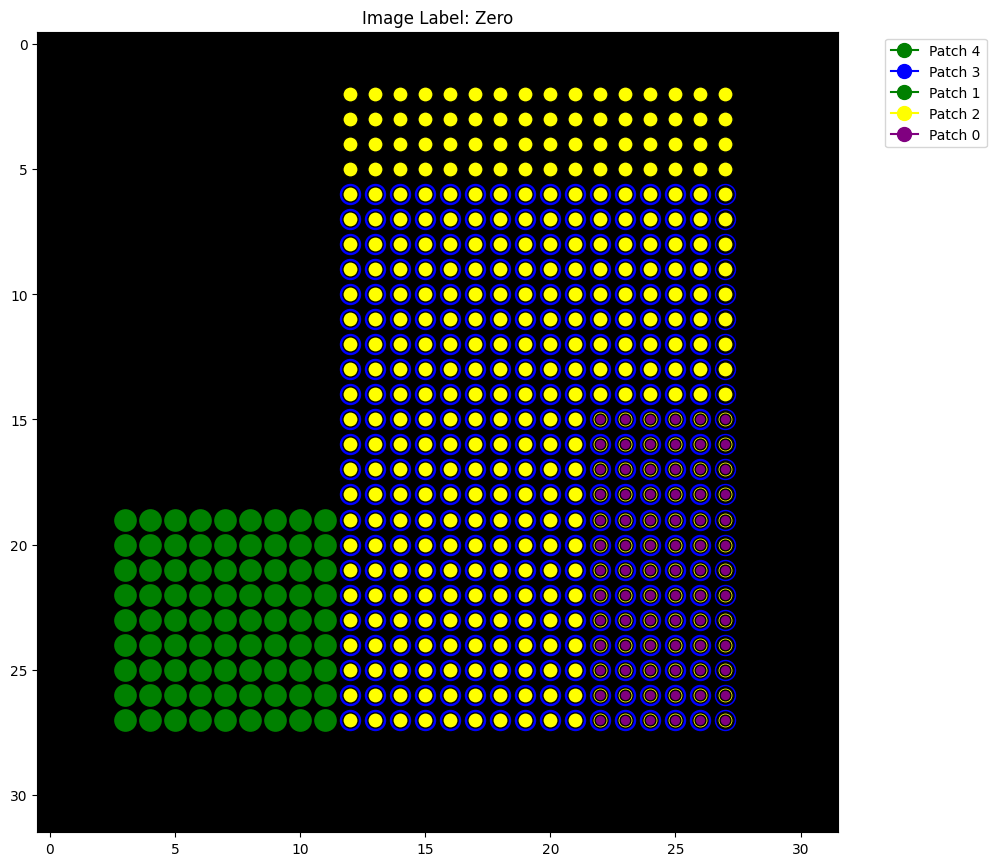

Minimum values of patches


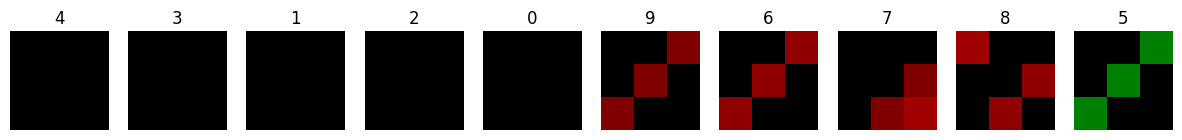

Maximum values of patches


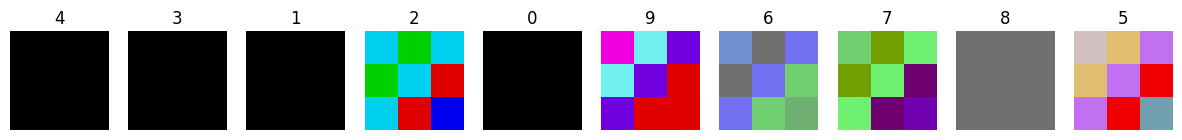

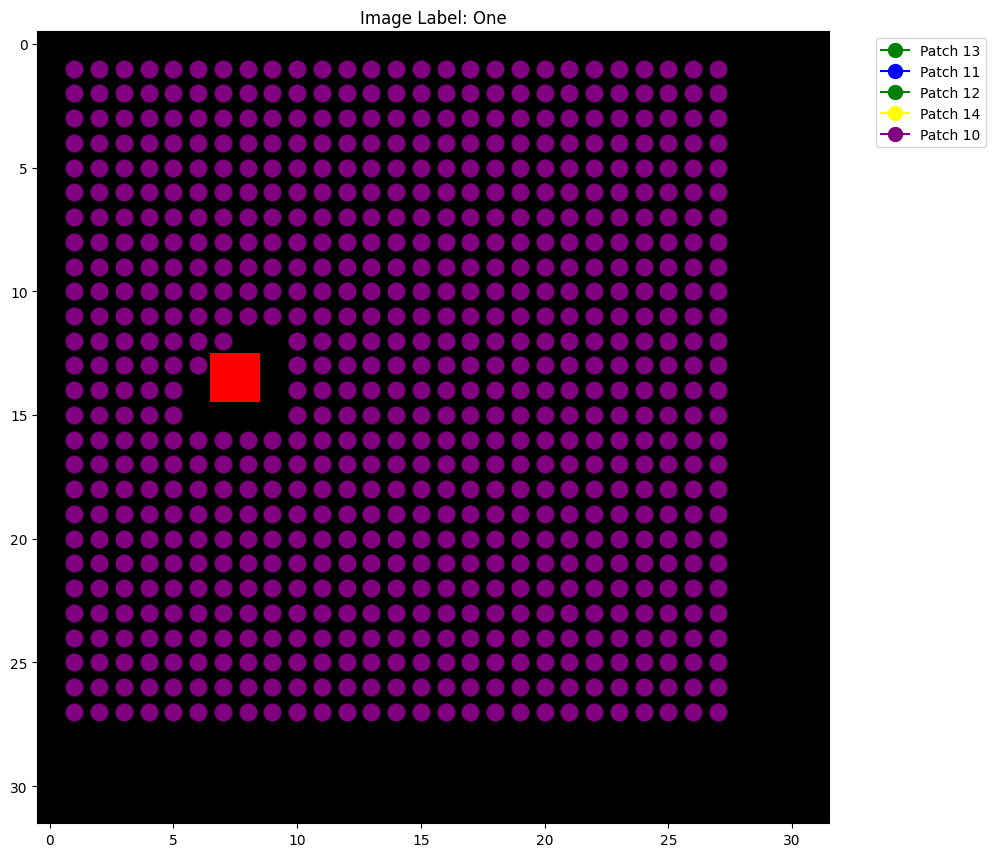

Minimum values of patches


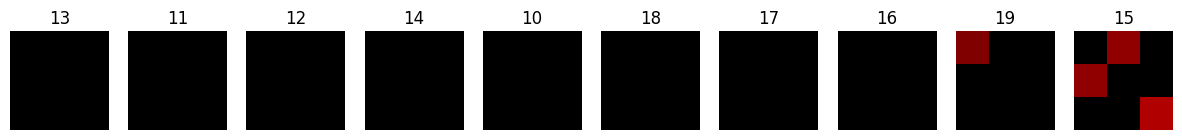

Maximum values of patches


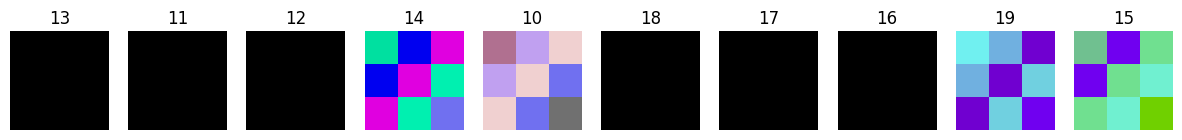

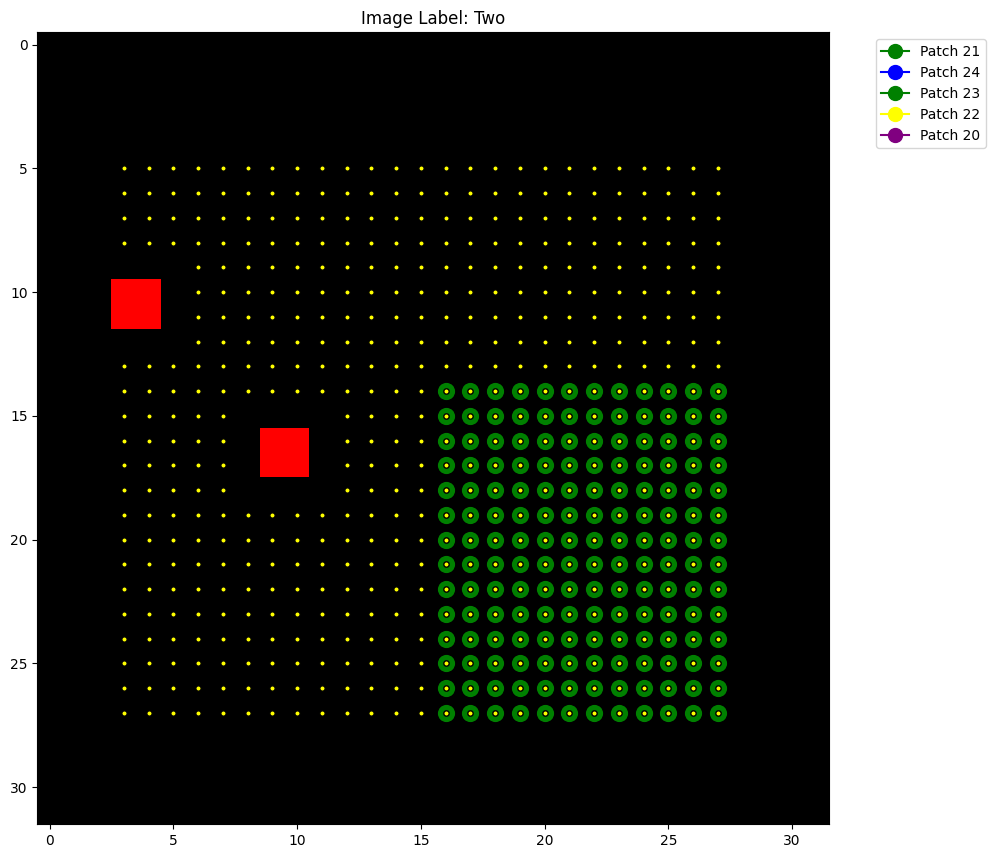

Minimum values of patches


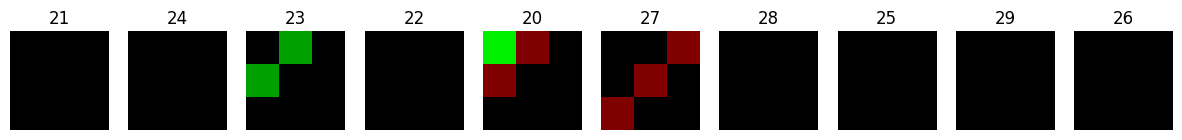

Maximum values of patches


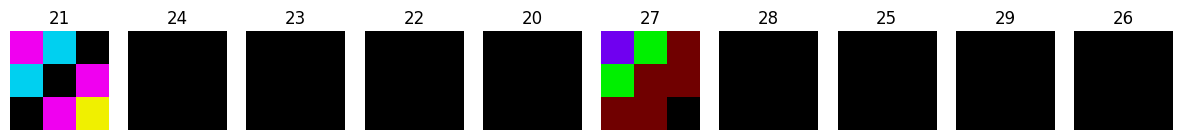

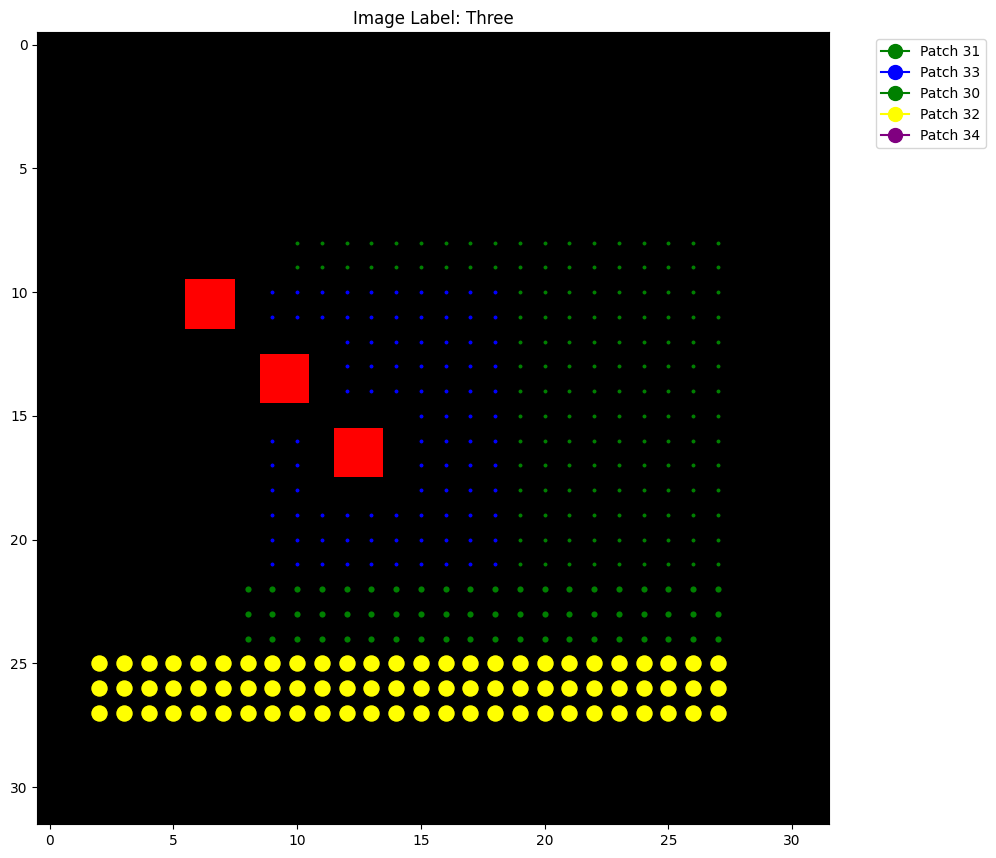

Minimum values of patches


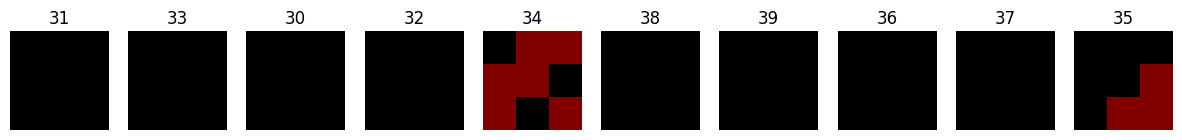

Maximum values of patches


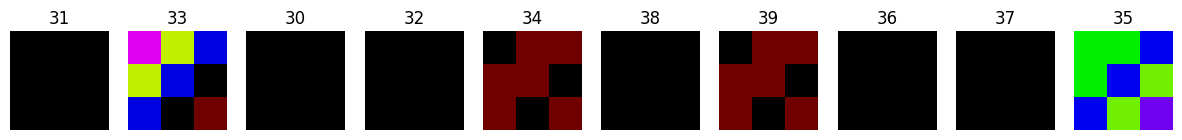

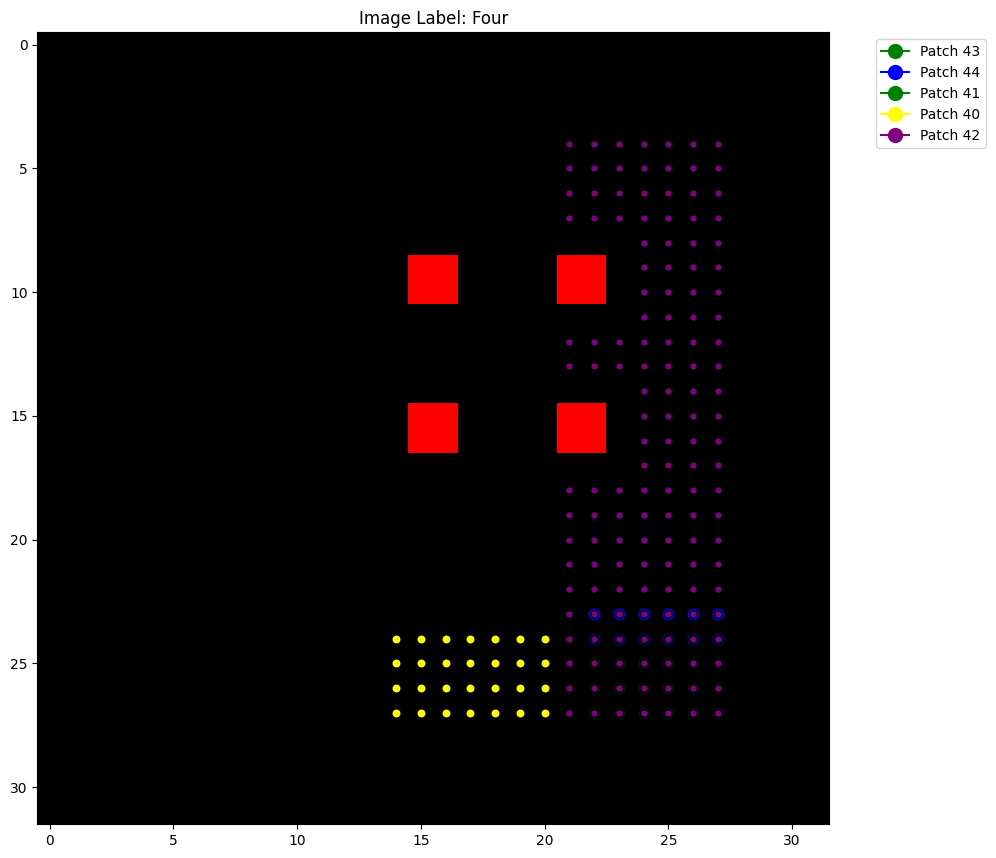

Minimum values of patches


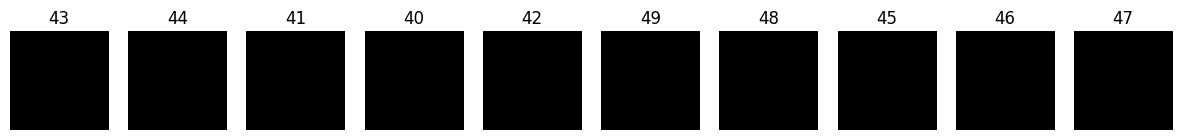

Maximum values of patches


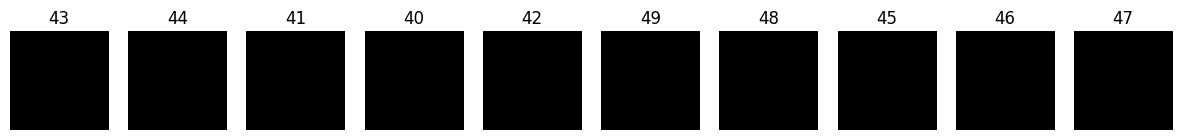

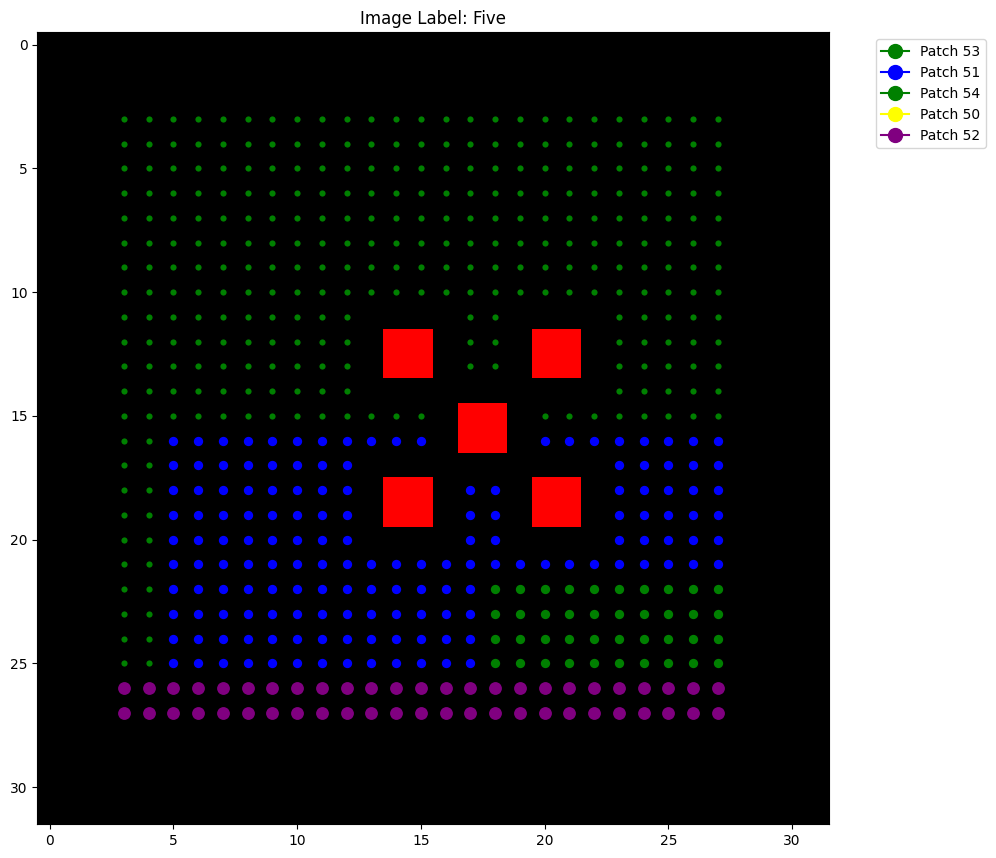

Minimum values of patches


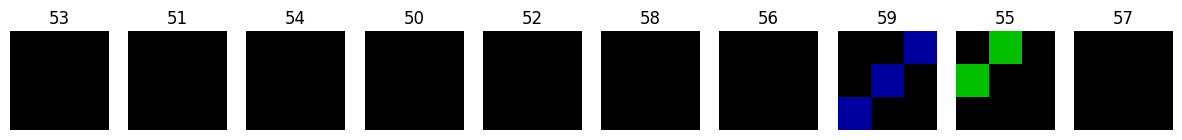

Maximum values of patches


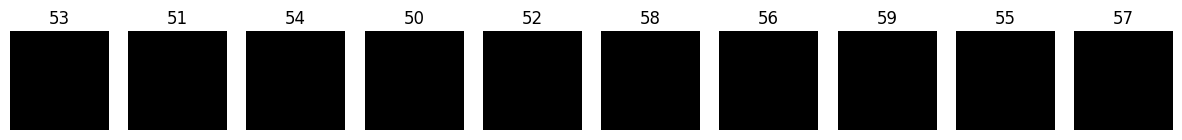

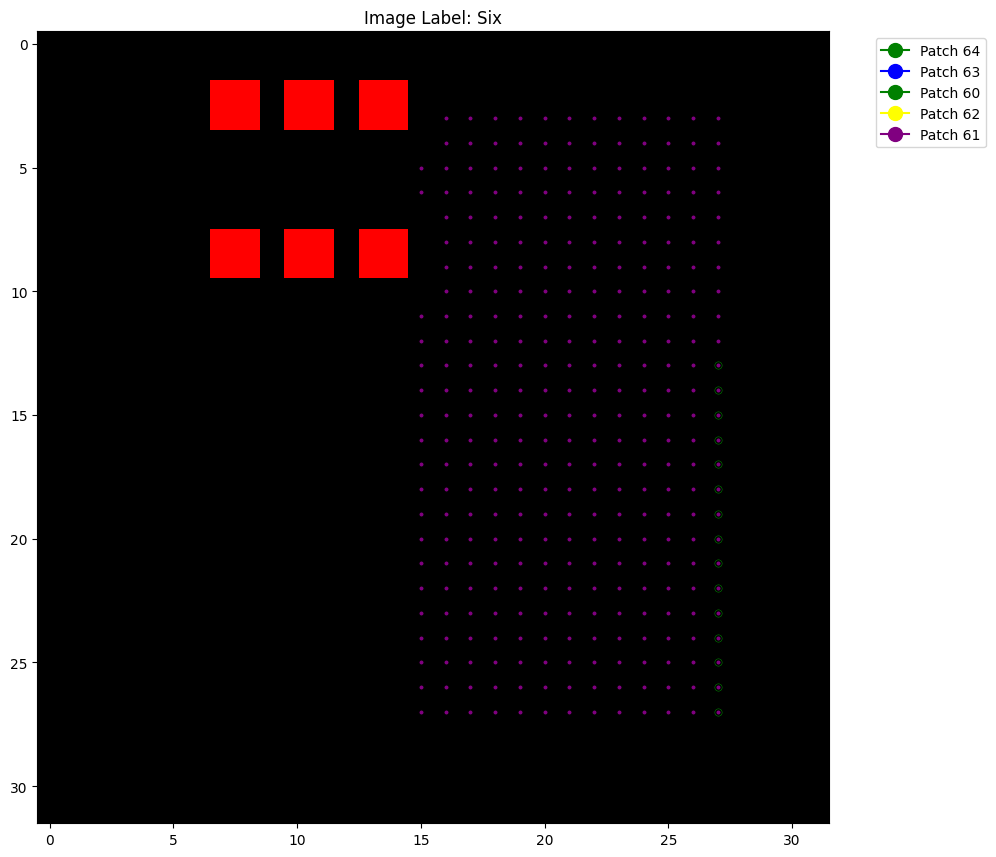

Minimum values of patches


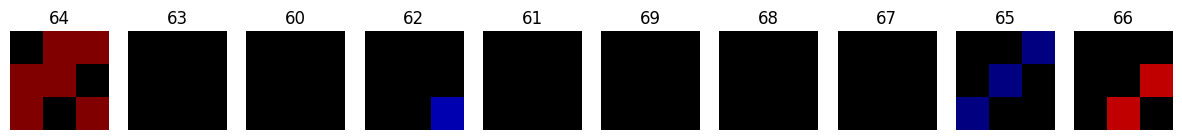

Maximum values of patches


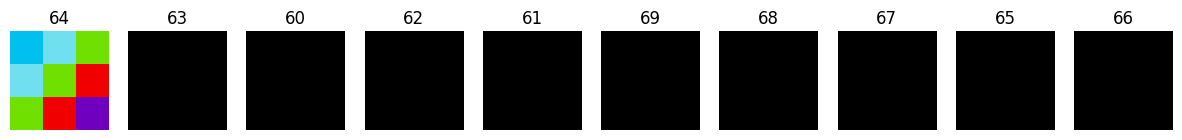

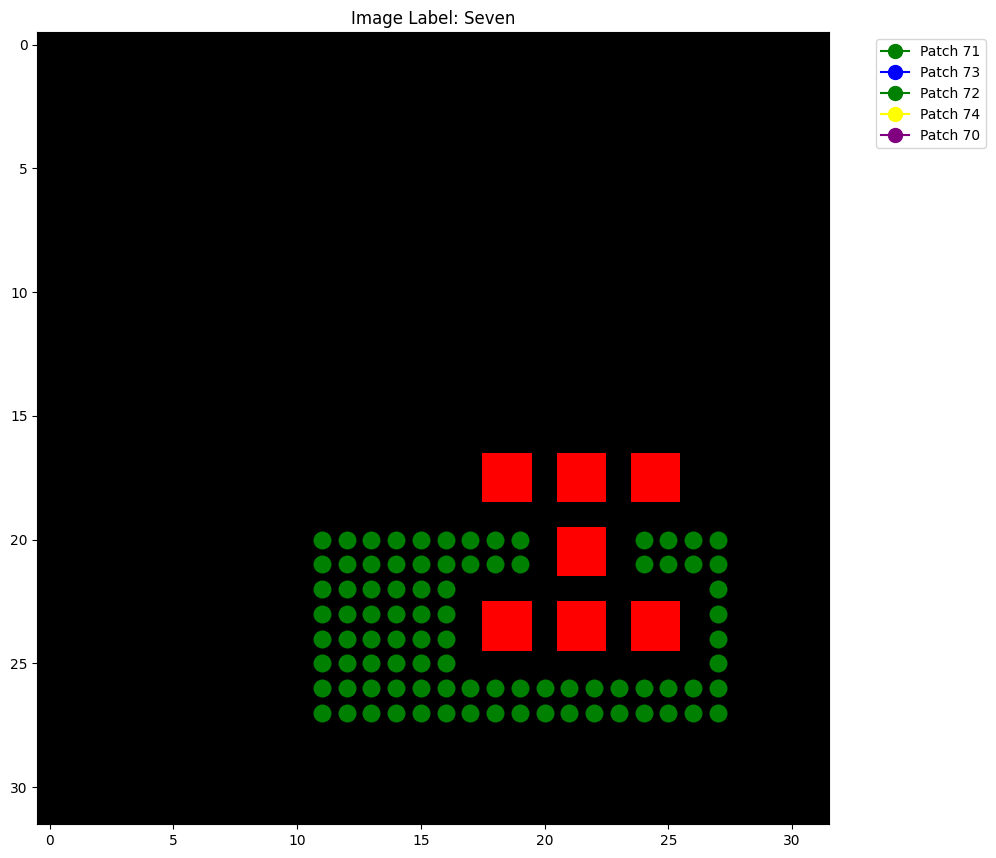

Minimum values of patches


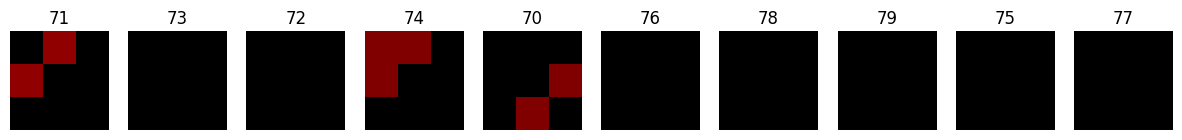

Maximum values of patches


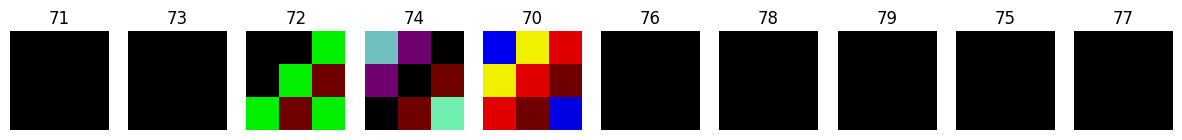

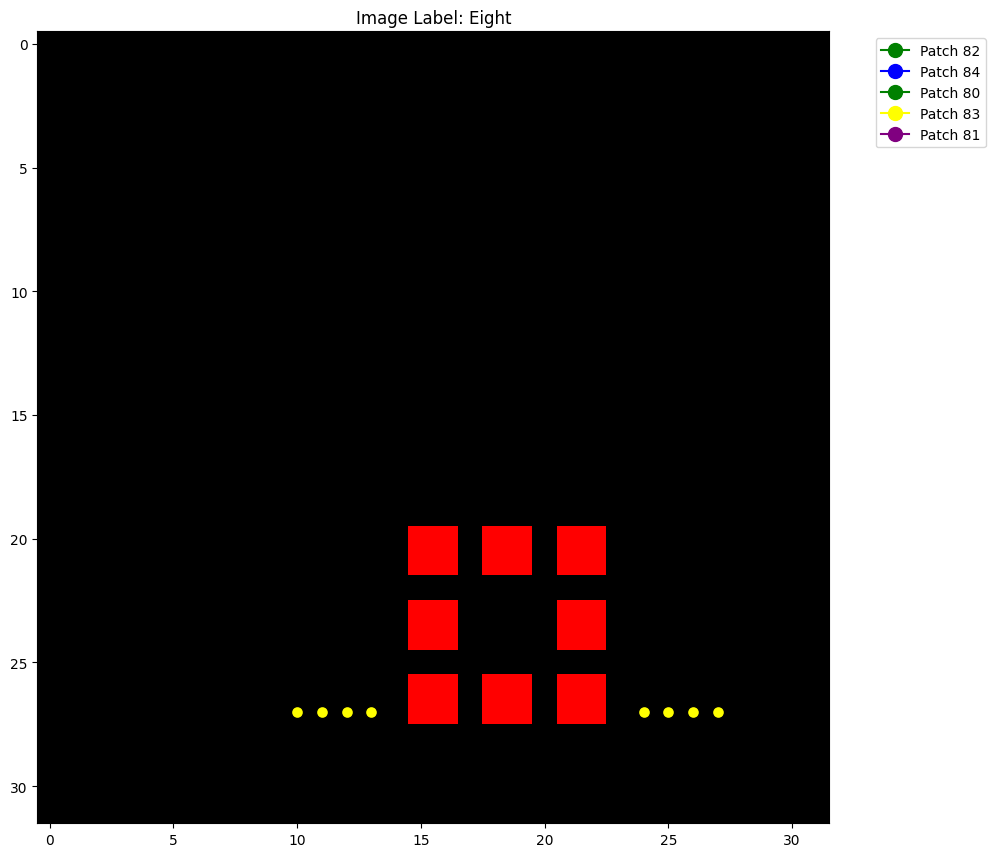

Minimum values of patches


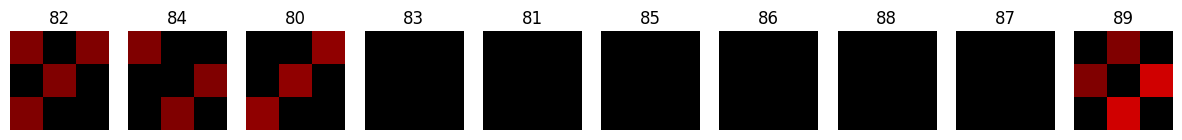

Maximum values of patches


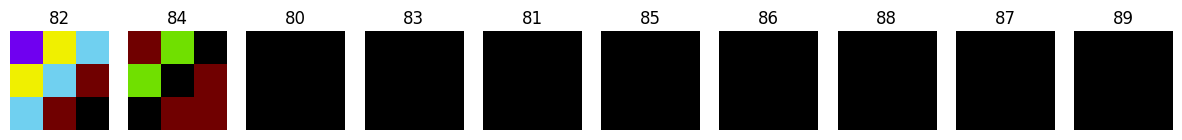

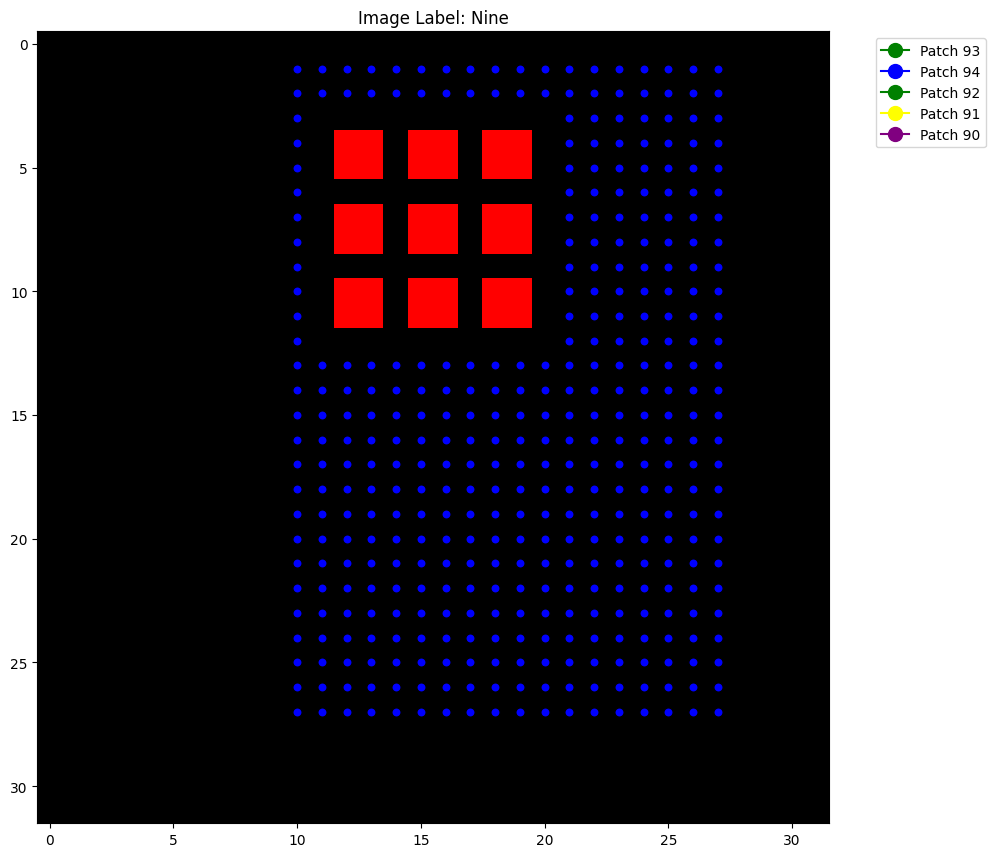

Minimum values of patches


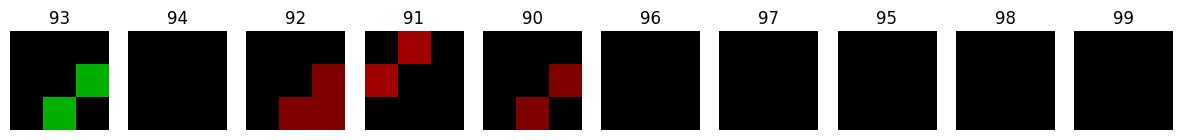

Maximum values of patches


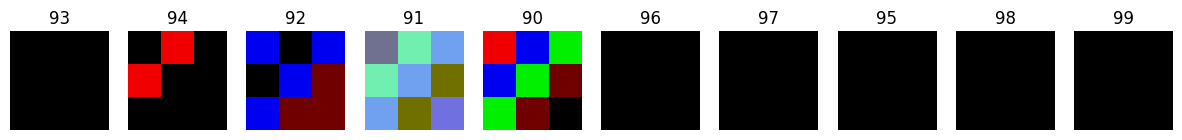

In [ ]:
#Plot extreme patches on images

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_patches_in_images(patch_list_pos, patch_list_neg, images, image_labels):
    all_results = {}
    
    # Define a list of colors
    colors = ['green', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink']
    
    for img_index, (image, label) in enumerate(zip(images, image_labels)):
        results = []
        legend_elements = []  # List to hold the legend elements
        heatmaps = np.zeros_like(image, dtype=float)

        # Plot the main image with dots
        fig_main, ax_main = plt.subplots(figsize=(10, 10))
        ax_main.imshow(image, cmap='gray')
        ax_main.set_title(f'Image Label: {label}')

        for patch_idx, (patch_pos, patch_neg) in enumerate(zip(patch_list_pos, patch_list_neg)):
            patch = patch_pos if patch_pos.weight > 0 else patch_neg
            marker_style = 'o' if patch_pos.weight > 0 else 'X'
            
            # Use the new find_patches_in_image function
            patch_search_results = find_patches_in_image(image, [patch], targeted_search=True, avg=False)
            
            color = colors[patch_idx % len(colors)]
            for patch_id, patch_coords in patch_search_results:
                for coord in patch_coords:
                    # Plot the position with the chosen marker style
                    ax_main.scatter(coord[1]+1, coord[0]+1, color=color, s=abs(patch.weight*15), marker=marker_style, edgecolors='black', linewidths=1)
                    results.append((patch_id, coord[0], coord[1]))
            
            # Add a legend element for each patch
            legend_elements.append(Line2D([0], [0], marker=marker_style, color=color, label=f'Patch {patch.ID}', markersize=10, markerfacecolor=color, markeredgewidth=1))

        # Add the legend outside of the main plot
        ax_main.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        print("Minimum values of patches")
        # Plot each patch in a separate figure
        fig_patches, axs = plt.subplots(1, len(patch_list_pos) + len(patch_list_neg), figsize=(15, 3))
        if len(patch_list_pos) + len(patch_list_neg) == 1:
            axs = [axs]

        for patch_idx, patch in enumerate(patch_list_pos + patch_list_neg):
            patch_image = patch.visualize_patch_info()  # Visualize the patch
            axs[patch_idx].imshow(patch_image)
            axs[patch_idx].set_title(f'{patch.ID}')
            axs[patch_idx].axis('off')  # Hide the axis

        plt.show()
        print("Maximum values of patches")
        # Plot each patch in a separate figure
        fig_patches, axs = plt.subplots(1, len(patch_list_pos) + len(patch_list_neg), figsize=(15, 3))
        if len(patch_list_pos) + len(patch_list_neg) == 1:
            axs = [axs]

        for patch_idx, patch in enumerate(patch_list_pos + patch_list_neg):
            patch_image = patch.visualize_patch_info(polarity=1)  # Visualize the patch
            axs[patch_idx].imshow(patch_image)
            axs[patch_idx].set_title(f'{patch.ID}')
            #axs[patch_idx].set_title(f'{patch.weight}')
            axs[patch_idx].axis('off')  # Hide the axis
 
        plt.show()

        all_results[img_index] = results
    
    return all_results




for index, image in enumerate(X_test_org[0:len(trained_labels)]):
    # Example usage: extreme_patches[Class, polarity, adjusted_index]
    patches_to_search_pos = [extreme_patches[Y_test_org[index]][1][n_extreme_patches-k-1] for k in range(5)]
    patches_to_search_neg = [extreme_patches[Y_test_org[index]][0][k] for k in range(5)]
    show_results = plot_patches_in_images(patches_to_search_pos, patches_to_search_neg, [image], [labels[Y_test_org[index]]])

In [ ]:
for i in range(5):
    print(extreme_patches[1][1][i].found_in_images)
    print(extreme_patches[0][1][i].total_count)
print(extreme_patches.shape)

{}
0
{}
0
{}
0
{}
0
{}
0
(10, 2, 5)


In [ ]:

def get_5x5_binary_mask(image, patch, all_detected_patches):
    """
    For the given patch in the image, this function checks a 5x5 region around it
    to see if the same patch appears in any of the positions. Returns a 5x5 binary mask.
    """
    
    mask = np.zeros((5, 5), dtype=bool)
    patch_info = patch.patch_info
    patch_size = patch_info.shape[0]  # Assuming patches are square (3x3)
    center_offset = patch_size // 2  # Offset from the patch's top-left to its center
    
    # Check each position in the 5x5 region
    for i in range(5):
        for j in range(5):
            x_offset = i - 2  # -2 to account for the center of the 5x5 mask
            y_offset = j - 2  # Same as above
            
            # Check the coordinates for this offset
            x_center = patch.x + center_offset + x_offset
            y_center = patch.y + center_offset + y_offset
            
            # Check if there's a detected patch around these coordinates
            for detected_patch in all_detected_patches:
                if (abs(detected_patch.x - x_center) <= center_offset) and (abs(detected_patch.y - y_center) <= center_offset):
                    mask[i, j] = True
                    break
                    
    return mask

def get_masks_for_all_patches(image, patches_to_search):
    all_detected_patches = find_patches_in_image(image, patches_to_search)
    masks = {}
    for patch in all_detected_patches:
        masks[patch.ID] = get_5x5_binary_mask(image, patch, all_detected_patches)
    return masks

""" # Example Usage
image = X_test_org[0]
example_masks = get_masks_for_all_patches(image, extreme_patches[Y_test_org[0], 0, :])

# Displaying the masks for visualization
for patch_id, mask in example_masks.items():
    plt.imshow(mask, cmap="gray")
    plt.title(f"5x5 Mask for Patch {patch_id}")
    plt.show() """

' # Example Usage\nimage = X_test_org[0]\nexample_masks = get_masks_for_all_patches(image, extreme_patches[Y_test_org[0], 0, :])\n\n# Displaying the masks for visualization\nfor patch_id, mask in example_masks.items():\n    plt.imshow(mask, cmap="gray")\n    plt.title(f"5x5 Mask for Patch {patch_id}")\n    plt.show() '

In [ ]:
extreme_patches.shape

(10, 2, 5)

In [ ]:
print("Finding patches in images...")
X_test_all_results = find_patches_in_images(X_test_org, Y_test_org, extreme_patches)
X_train_all_results = find_patches_in_images(X_train_org, Y_train_org, extreme_patches)

Finding patches in images...


Processing images: 100%|██████████| 500/500 [00:03<00:00, 155.04it/s]

Counting patches...


'print("Identifying frequent patches...")\nX_test_frequent_patches = get_frequent_patches(X_test_patch_counts, Y_test_org)\nprint("Identifying origin patches IDs...")\nX_test_origin_patches = get_origin_patches(X_test_patch_counts, X_test_all_results)\nprint("Getting patch coordinates...")\nX_test_patch_coordinates = get_patch_coordinates(X_test_all_results, X_test_frequent_patches) '

In [ ]:
#find anchors on test data
counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
for image_results in X_test_all_results:
    for patch in image_results:
        patch_id = patch[0]
        counts[patch_id] += 1

# Initialize origin_points
origin_points = [[] for _ in range(tm.number_of_classes)]
# Get anchor points for each class
for Class in range(tm.number_of_classes):
    # Sort per class, args are IDs, get two most common
    anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:]
    #IDs now per class
    for anchor_id in anchor_ids: #per ID
        # Find the coordinates of the anchor patches
        for image_results in X_test_all_results: 
            for result in image_results:
                if result[0] == anchor_id:
                    origin_points[Class].append(result[1:])  # Assuming result[1] has the coordinates
                else:
                    origin_points[Class].append([0,0]) 

# Now pass this to the encode_origin function
encoded_patches_test = encode_origin(X_test_org, Y_test_org, origin_points, 2)


0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99


In [ ]:
#find anchors on train data
counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
for image_results in X_train_all_results:
    for patch in image_results:
        patch_id = patch[0]
        counts[patch_id] += 1
anchors_id = []

# Initialize origin_points
origin_points = [[] for _ in range(tm.number_of_classes)]
# Get anchor points for each class
for Class in range(tm.number_of_classes):
    # Sort per class, args are IDs, get two most common
    anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:]
    #IDs now per class
    for anchor_id in anchor_ids: #per ID
        # Find the coordinates of the anchor patches
        for image_results in X_test_all_results: 
            for result in image_results:
                if result[0] == anchor_id:
                    origin_points[Class].append(result[1:])  # Assuming result[1] has the coordinates
                else:
                    origin_points[Class].append([0,0]) 

# Now pass this to the encode_origin function
encoded_patches_train = encode_origin(X_train_org, Y_train_org, origin_points, 2)


0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152


In [ ]:

# Create the windowed datasets
X_train, dataset_dimensions = create_windowed_dataset(thermometer_encode(X_train_org), thermometer_encode(encoded_patches_train), patch_dim=patch_dim)
X_test,  dataset_dimensions = create_windowed_dataset(thermometer_encode(X_test_org), thermometer_encode(encoded_patches_test), patch_dim=patch_dim)



In [ ]:
#Train the TM and record results
f = open("cifar2_%.1f_%d_%d_%d_%d_%d_withoutSS Gradient.txt" % (s, clauses, T, step, visual_tokens, scaling), "w+")
logTrain = np.zeros((epochs, X_train.shape[0]), dtype=np.uint8)
logTest =  np.zeros((epochs, X_test.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        if visual_tokens:
                tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        else:
                tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(3,3), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest[epoch] = (tm.predict(X_test))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train) == Y_train).mean()
                logTrain[epoch] = (tm.predict(X_train))*label
                
                number_of_includes = 0
                for i in range(2):
                        for j in range(clauses):
                                number_of_includes += tm.number_of_include_actions(i, j)
                number_of_includes /= 2*clauses

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f %.2f" % (label, epoch, number_of_includes, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                print("%d %d %.2f %.2f %.2f %.2f %.2f" % (label, epoch, number_of_includes, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                f.flush()
f.close()



Training:
10 labels used: [0 1 2 3 4 5 6 7 8 9]
Training pictures: 500
Testing:
10 labels used: [0 1 2 3 4 5 6 7 8 9]
Maximum achievable accuracy: 100.0
..adjusting
Testing pictures: 100

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-22 18:25:37,779 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:19<09:17, 19.22s/it]

0 0 84.10 11.00 12.00 1.05 3.08


  7%|▋         | 2/30 [00:37<08:43, 18.69s/it]

0 1 86.70 17.00 19.20 0.27 3.03


 10%|█         | 3/30 [00:55<08:17, 18.44s/it]

0 2 137.65 15.00 19.60 0.23 3.03


 13%|█▎        | 4/30 [01:14<08:00, 18.47s/it]

0 3 163.35 8.00 9.60 0.22 3.10


 17%|█▋        | 5/30 [01:32<07:37, 18.31s/it]

0 4 166.40 23.00 28.00 0.22 3.01


 20%|██        | 6/30 [01:50<07:18, 18.28s/it]

0 5 187.35 26.00 26.20 0.21 3.05


 23%|██▎       | 7/30 [02:08<07:01, 18.32s/it]

0 6 186.30 26.00 26.20 0.22 3.05


 27%|██▋       | 8/30 [02:27<06:42, 18.30s/it]

0 7 197.60 23.00 31.80 0.21 3.08


 30%|███       | 9/30 [02:45<06:25, 18.34s/it]

0 8 207.85 21.00 28.20 0.21 3.04


 33%|███▎      | 10/30 [03:15<07:16, 21.82s/it]

0 9 242.75 25.00 24.00 0.49 4.89


 37%|███▋      | 11/30 [03:44<07:36, 24.05s/it]

0 10 233.85 21.00 26.40 0.40 4.72


 40%|████      | 12/30 [04:14<07:44, 25.79s/it]

0 11 251.80 24.00 22.40 0.38 4.76


 43%|████▎     | 13/30 [04:42<07:33, 26.66s/it]

0 12 268.65 27.00 32.40 0.37 4.88


 47%|████▋     | 14/30 [05:11<07:16, 27.29s/it]

0 13 245.55 24.00 29.80 0.35 4.77


 50%|█████     | 15/30 [05:40<06:55, 27.70s/it]

0 14 259.45 24.00 26.20 0.35 4.71


 53%|█████▎    | 16/30 [06:09<06:36, 28.30s/it]

0 15 275.45 29.00 27.60 0.36 4.75


 57%|█████▋    | 17/30 [06:38<06:11, 28.54s/it]

0 16 312.20 31.00 30.60 0.35 5.02


 60%|██████    | 18/30 [07:07<05:43, 28.59s/it]

0 17 287.90 33.00 35.40 0.36 4.86


 63%|██████▎   | 19/30 [07:36<05:15, 28.71s/it]

0 18 308.55 27.00 30.60 0.35 4.75


 67%|██████▋   | 20/30 [08:06<04:49, 28.99s/it]

0 19 316.85 29.00 29.80 0.37 4.82


 70%|███████   | 21/30 [08:35<04:21, 29.08s/it]

0 20 304.90 30.00 29.80 0.38 4.84


 73%|███████▎  | 22/30 [09:05<03:55, 29.38s/it]

0 21 281.05 33.00 36.20 0.41 4.82


 77%|███████▋  | 23/30 [09:35<03:26, 29.44s/it]

0 22 296.70 21.00 24.80 0.35 4.92


 80%|████████  | 24/30 [10:05<02:58, 29.74s/it]

0 23 283.45 26.00 37.40 0.37 4.94


 83%|████████▎ | 25/30 [10:35<02:28, 29.71s/it]

0 24 289.65 26.00 34.40 0.37 4.98


 87%|████████▋ | 26/30 [11:04<01:58, 29.55s/it]

0 25 289.80 27.00 34.20 0.39 4.93


 90%|█████████ | 27/30 [11:33<01:27, 29.31s/it]

0 26 310.95 31.00 35.20 0.35 4.80


 93%|█████████▎| 28/30 [12:02<00:58, 29.37s/it]

0 27 302.20 27.00 33.40 0.34 4.81


 97%|█████████▋| 29/30 [12:32<00:29, 29.38s/it]

0 28 300.55 27.00 34.60 0.36 4.91


100%|██████████| 30/30 [13:01<00:00, 26.04s/it]


0 29 310.85 33.00 36.60 0.35 4.84

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-22 18:38:38,972 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:29<14:10, 29.33s/it]

1 0 59.65 10.00 10.20 1.70 4.62


  7%|▋         | 2/30 [00:58<13:34, 29.09s/it]

1 1 126.90 10.00 10.40 0.45 4.72


 10%|█         | 3/30 [01:28<13:24, 29.78s/it]

1 2 173.95 10.00 10.00 0.48 5.10


 13%|█▎        | 4/30 [01:58<12:47, 29.53s/it]

1 3 196.50 6.00 11.00 0.44 4.83


 17%|█▋        | 5/30 [02:27<12:16, 29.46s/it]

1 4 240.75 26.00 20.20 0.40 4.84


 20%|██        | 6/30 [02:57<11:49, 29.57s/it]

1 5 256.10 10.00 10.80 0.38 4.91


 23%|██▎       | 7/30 [03:27<11:22, 29.68s/it]

1 6 254.05 19.00 22.20 0.41 4.94


 27%|██▋       | 8/30 [03:57<10:55, 29.79s/it]

1 7 250.05 21.00 20.40 0.42 5.17


 30%|███       | 9/30 [04:26<10:26, 29.82s/it]

1 8 279.40 20.00 22.60 0.44 4.91


 33%|███▎      | 10/30 [04:56<09:56, 29.81s/it]

1 9 259.15 22.00 22.00 0.39 4.92


 37%|███▋      | 11/30 [05:26<09:27, 29.88s/it]

1 10 250.00 20.00 21.60 0.39 4.94


 40%|████      | 12/30 [05:56<08:57, 29.89s/it]

1 11 244.05 22.00 21.40 0.37 4.99


 43%|████▎     | 13/30 [06:26<08:27, 29.83s/it]

1 12 261.30 24.00 22.60 0.39 4.96


 47%|████▋     | 14/30 [06:56<07:57, 29.84s/it]

1 13 273.90 23.00 22.40 0.39 4.96


 50%|█████     | 15/30 [07:26<07:27, 29.85s/it]

1 14 289.55 20.00 20.80 0.37 4.96


 53%|█████▎    | 16/30 [07:55<06:57, 29.81s/it]

1 15 262.75 19.00 24.80 0.39 4.96


 57%|█████▋    | 17/30 [08:25<06:27, 29.84s/it]

1 16 277.80 24.00 20.60 0.38 4.95


 60%|██████    | 18/30 [08:55<05:59, 29.92s/it]

1 17 284.10 24.00 24.40 0.38 5.03


 63%|██████▎   | 19/30 [09:25<05:29, 29.92s/it]

1 18 265.55 26.00 20.40 0.40 4.93


 67%|██████▋   | 20/30 [09:55<04:58, 29.90s/it]

1 19 241.30 26.00 25.00 0.38 4.94


 70%|███████   | 21/30 [10:25<04:28, 29.84s/it]

1 20 230.40 22.00 21.80 0.36 4.87


 73%|███████▎  | 22/30 [10:55<03:59, 29.88s/it]

1 21 246.45 22.00 21.00 0.38 5.00


 77%|███████▋  | 23/30 [11:25<03:29, 29.91s/it]

1 22 282.20 31.00 24.40 0.38 5.01


 80%|████████  | 24/30 [11:55<02:59, 29.88s/it]

1 23 270.00 23.00 24.80 0.37 4.93


 83%|████████▎ | 25/30 [12:24<02:29, 29.88s/it]

1 24 273.75 24.00 23.20 0.38 4.93


 87%|████████▋ | 26/30 [12:54<01:59, 29.88s/it]

1 25 266.55 23.00 21.20 0.38 4.92


 90%|█████████ | 27/30 [13:24<01:29, 29.92s/it]

1 26 255.35 21.00 25.20 0.39 5.07


 93%|█████████▎| 28/30 [13:54<00:59, 29.94s/it]

1 27 272.00 28.00 25.20 0.37 4.94


 97%|█████████▋| 29/30 [14:24<00:29, 29.95s/it]

1 28 297.90 21.00 22.00 0.39 4.99


100%|██████████| 30/30 [14:54<00:00, 29.83s/it]


1 29 295.10 20.00 24.20 0.38 5.00

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-22 18:53:33,818 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:30<14:43, 30.45s/it]

2 0 151.00 11.00 10.20 1.77 4.75


  7%|▋         | 2/30 [00:59<13:51, 29.68s/it]

2 1 167.75 11.00 10.80 0.40 4.83


 10%|█         | 3/30 [01:28<13:17, 29.54s/it]

2 2 184.05 12.00 14.60 0.40 4.87


 13%|█▎        | 4/30 [01:58<12:46, 29.48s/it]

2 3 228.55 10.00 9.80 0.41 4.81


 17%|█▋        | 5/30 [02:27<12:18, 29.53s/it]

2 4 258.15 10.00 9.80 0.40 4.92


 20%|██        | 6/30 [02:57<11:48, 29.51s/it]

2 5 289.05 12.00 16.00 0.41 4.84


 23%|██▎       | 7/30 [03:26<11:17, 29.47s/it]

2 6 327.65 12.00 11.60 0.41 4.86


 27%|██▋       | 8/30 [03:56<10:51, 29.61s/it]

2 7 310.40 12.00 17.00 0.40 4.94


 30%|███       | 9/30 [04:26<10:21, 29.60s/it]

2 8 224.70 16.00 16.80 0.39 4.90


 33%|███▎      | 10/30 [04:55<09:51, 29.58s/it]

2 9 274.50 17.00 19.20 0.39 4.99


 37%|███▋      | 11/30 [05:25<09:21, 29.53s/it]

2 10 374.05 18.00 21.40 0.37 4.93


 40%|████      | 12/30 [05:54<08:51, 29.52s/it]

2 11 385.15 19.00 19.80 0.41 4.90


 43%|████▎     | 13/30 [06:24<08:22, 29.56s/it]

2 12 376.60 16.00 16.20 0.36 4.91


 47%|████▋     | 14/30 [06:55<08:00, 30.02s/it]

2 13 344.30 21.00 15.40 0.37 4.92


 50%|█████     | 15/30 [07:25<07:28, 29.87s/it]

2 14 320.35 12.00 19.40 0.35 4.90


 53%|█████▎    | 16/30 [07:54<06:57, 29.82s/it]

2 15 296.15 4.00 13.20 0.37 4.92


 57%|█████▋    | 17/30 [08:24<06:28, 29.85s/it]

2 16 381.40 14.00 18.80 0.37 4.97


 60%|██████    | 18/30 [08:54<05:57, 29.79s/it]

2 17 354.95 17.00 23.40 0.36 4.93


 63%|██████▎   | 19/30 [09:23<05:26, 29.70s/it]

2 18 366.05 15.00 20.40 0.37 4.95


 67%|██████▋   | 20/30 [09:53<04:57, 29.72s/it]

2 19 336.45 17.00 21.00 0.34 4.92


 70%|███████   | 21/30 [10:23<04:28, 29.79s/it]

2 20 349.65 16.00 18.80 0.37 4.96


 73%|███████▎  | 22/30 [10:53<03:58, 29.82s/it]

2 21 357.75 15.00 17.20 0.36 4.97


 77%|███████▋  | 23/30 [11:23<03:28, 29.80s/it]

2 22 307.20 13.00 15.00 0.37 4.99


 80%|████████  | 24/30 [11:52<02:58, 29.74s/it]

2 23 310.70 15.00 19.60 0.36 4.92


 83%|████████▎ | 25/30 [12:22<02:28, 29.71s/it]

2 24 341.15 22.00 22.80 0.37 4.93


 87%|████████▋ | 26/30 [12:52<01:58, 29.71s/it]

2 25 364.85 16.00 17.80 0.35 4.93


 90%|█████████ | 27/30 [13:21<01:29, 29.73s/it]

2 26 348.25 17.00 20.40 0.36 4.94


 93%|█████████▎| 28/30 [13:51<00:59, 29.75s/it]

2 27 358.40 17.00 21.40 0.36 4.89


 97%|█████████▋| 29/30 [14:21<00:29, 29.80s/it]

2 28 348.80 18.00 25.00 0.34 4.92


100%|██████████| 30/30 [14:51<00:00, 29.71s/it]


2 29 372.50 21.00 22.60 0.36 4.97

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-22 19:08:25,212 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:29<14:29, 29.99s/it]

3 0 34.75 12.00 11.20 1.73 4.69


  7%|▋         | 2/30 [00:59<13:50, 29.67s/it]

3 1 99.10 16.00 13.40 0.44 4.94


 10%|█         | 3/30 [01:28<13:19, 29.60s/it]

3 2 160.95 19.00 19.00 0.43 4.89


 13%|█▎        | 4/30 [01:58<12:48, 29.55s/it]

3 3 194.65 19.00 22.00 0.41 4.94


 17%|█▋        | 5/30 [02:27<12:15, 29.42s/it]

3 4 254.65 21.00 21.20 0.39 4.85


 20%|██        | 6/30 [02:57<11:48, 29.54s/it]

3 5 213.05 8.00 10.40 0.40 4.90


 23%|██▎       | 7/30 [03:26<11:19, 29.53s/it]

3 6 217.50 8.00 10.00 0.38 4.85


 27%|██▋       | 8/30 [03:56<10:52, 29.64s/it]

3 7 243.95 29.00 30.00 0.42 4.98


 30%|███       | 9/30 [04:26<10:22, 29.65s/it]

3 8 277.15 25.00 23.00 0.39 4.93


 33%|███▎      | 10/30 [04:56<09:55, 29.75s/it]

3 9 257.40 20.00 19.60 0.37 4.98


 37%|███▋      | 11/30 [05:26<09:27, 29.85s/it]

3 10 274.30 26.00 25.60 0.39 4.96


 40%|████      | 12/30 [05:56<08:58, 29.92s/it]

3 11 286.40 24.00 27.40 0.39 5.06


 43%|████▎     | 13/30 [06:26<08:27, 29.85s/it]

3 12 267.70 26.00 27.20 0.39 4.98


 47%|████▋     | 14/30 [06:56<07:58, 29.92s/it]

3 13 285.55 21.00 19.80 0.38 4.94


 50%|█████     | 15/30 [07:26<07:29, 29.97s/it]

3 14 291.60 22.00 22.40 0.38 4.99


 53%|█████▎    | 16/30 [07:56<06:59, 29.95s/it]

3 15 286.95 25.00 27.20 0.38 4.96


 57%|█████▋    | 17/30 [08:26<06:28, 29.90s/it]

3 16 285.40 11.00 10.20 0.38 4.95


 60%|██████    | 18/30 [08:56<05:59, 29.99s/it]

3 17 293.40 28.00 23.80 0.39 4.97


 63%|██████▎   | 19/30 [09:26<05:32, 30.19s/it]

3 18 286.70 26.00 25.60 0.43 5.09


 67%|██████▋   | 20/30 [09:56<04:59, 29.92s/it]

3 19 307.30 25.00 23.00 0.36 4.90


 70%|███████   | 21/30 [10:25<04:27, 29.69s/it]

3 20 266.95 24.00 23.20 0.38 4.85


 73%|███████▎  | 22/30 [10:54<03:56, 29.56s/it]

3 21 270.05 21.00 22.80 0.37 4.81


 77%|███████▋  | 23/30 [11:25<03:30, 30.01s/it]

3 22 311.55 27.00 28.00 0.37 4.87


 80%|████████  | 24/30 [11:55<02:59, 29.95s/it]

3 23 284.00 20.00 26.20 0.36 4.91


 83%|████████▎ | 25/30 [12:25<02:29, 29.93s/it]

3 24 293.65 26.00 23.60 0.37 4.97


 87%|████████▋ | 26/30 [12:55<02:00, 30.06s/it]

3 25 274.30 24.00 24.60 0.36 5.04


 90%|█████████ | 27/30 [13:25<01:30, 30.10s/it]

3 26 312.45 22.00 18.60 0.39 4.99


 93%|█████████▎| 28/30 [13:55<01:00, 30.04s/it]

3 27 291.15 28.00 28.60 0.38 5.05


 97%|█████████▋| 29/30 [14:25<00:29, 29.84s/it]

3 28 276.45 25.00 24.20 0.58 5.29


100%|██████████| 30/30 [14:54<00:00, 29.82s/it]


3 29 291.10 29.00 28.20 0.36 4.70

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-22 19:23:19,828 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:30<14:58, 30.97s/it]

4 0 98.60 9.00 10.00 1.66 4.57


  7%|▋         | 2/30 [01:00<14:04, 30.14s/it]

4 1 160.75 20.00 19.00 0.55 4.91


 10%|█         | 3/30 [01:28<13:11, 29.33s/it]

4 2 151.25 18.00 17.80 0.40 4.68


 13%|█▎        | 4/30 [01:57<12:33, 28.99s/it]

4 3 166.30 10.00 11.60 0.41 4.68


 17%|█▋        | 5/30 [02:26<12:07, 29.10s/it]

4 4 186.90 19.00 20.40 0.39 4.73


 20%|██        | 6/30 [02:55<11:36, 29.01s/it]

4 5 268.75 16.00 20.40 0.37 4.79


 23%|██▎       | 7/30 [03:24<11:06, 28.97s/it]

4 6 250.50 24.00 28.20 0.37 4.83


 27%|██▋       | 8/30 [03:53<10:38, 29.04s/it]

4 7 312.00 22.00 20.00 0.38 4.66


 30%|███       | 9/30 [04:24<10:19, 29.48s/it]

4 8 257.60 23.00 24.00 0.45 5.25


 33%|███▎      | 10/30 [04:53<09:48, 29.44s/it]

4 9 233.45 21.00 26.20 0.39 4.98


 37%|███▋      | 11/30 [05:22<09:17, 29.37s/it]

4 10 235.60 23.00 27.00 0.38 4.84


 40%|████      | 12/30 [05:52<08:50, 29.46s/it]

4 11 249.75 20.00 21.60 0.38 4.96


 43%|████▎     | 13/30 [06:23<08:29, 30.00s/it]

4 12 246.60 20.00 22.60 0.41 5.84


 47%|████▋     | 14/30 [06:53<08:01, 30.09s/it]

4 13 236.40 17.00 22.00 0.38 5.26


 50%|█████     | 15/30 [07:23<07:30, 30.00s/it]

4 14 251.15 14.00 21.20 0.39 4.93


 53%|█████▎    | 16/30 [07:53<06:59, 29.94s/it]

4 15 250.45 29.00 31.00 0.40 4.94


 57%|█████▋    | 17/30 [08:23<06:31, 30.13s/it]

4 16 290.20 21.00 25.20 0.39 5.01


 60%|██████    | 18/30 [08:54<06:02, 30.19s/it]

4 17 284.75 18.00 22.20 0.37 5.07


 63%|██████▎   | 19/30 [09:24<05:32, 30.21s/it]

4 18 295.45 23.00 23.20 0.43 5.00


 67%|██████▋   | 20/30 [09:54<05:01, 30.15s/it]

4 19 286.90 16.00 22.40 0.40 4.91


 70%|███████   | 21/30 [10:24<04:31, 30.22s/it]

4 20 295.20 27.00 28.00 0.40 4.98


 73%|███████▎  | 22/30 [10:55<04:01, 30.18s/it]

4 21 299.90 25.00 30.00 0.38 5.04


 77%|███████▋  | 23/30 [11:24<03:30, 30.05s/it]

4 22 323.80 21.00 24.80 0.39 4.90


 80%|████████  | 24/30 [11:55<03:00, 30.10s/it]

4 23 316.55 26.00 29.20 0.38 4.94


 83%|████████▎ | 25/30 [12:25<02:31, 30.27s/it]

4 24 326.90 28.00 29.60 0.40 5.02


 87%|████████▋ | 26/30 [12:55<02:00, 30.21s/it]

4 25 315.50 20.00 29.00 0.40 5.07


 90%|█████████ | 27/30 [13:25<01:30, 30.08s/it]

4 26 326.75 22.00 23.80 0.38 4.96


 93%|█████████▎| 28/30 [13:55<01:00, 30.03s/it]

4 27 311.20 25.00 30.60 0.40 4.88


 97%|█████████▋| 29/30 [14:25<00:30, 30.13s/it]

4 28 299.95 23.00 28.60 0.38 5.08


100%|██████████| 30/30 [14:55<00:00, 29.86s/it]


4 29 316.80 20.00 24.60 0.39 4.99

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-22 19:38:15,690 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:30<14:34, 30.16s/it]

5 0 84.25 15.00 18.60 1.85 4.74


  7%|▋         | 2/30 [00:59<13:51, 29.70s/it]

5 1 153.70 20.00 19.40 0.41 4.83


 10%|█         | 3/30 [01:29<13:22, 29.71s/it]

5 2 154.65 15.00 22.00 0.41 4.87


 13%|█▎        | 4/30 [01:58<12:51, 29.68s/it]

5 3 168.50 22.00 23.80 0.41 5.05


 17%|█▋        | 5/30 [02:28<12:17, 29.51s/it]

5 4 220.15 18.00 20.00 0.41 4.88


 20%|██        | 6/30 [02:57<11:46, 29.42s/it]

5 5 223.45 19.00 24.40 0.37 4.86


 23%|██▎       | 7/30 [03:26<11:16, 29.42s/it]

5 6 251.30 20.00 21.20 0.39 4.82


 27%|██▋       | 8/30 [03:56<10:46, 29.40s/it]

5 7 269.05 21.00 19.80 0.40 4.86


 30%|███       | 9/30 [04:25<10:19, 29.51s/it]

5 8 260.50 20.00 24.00 0.39 4.89


 33%|███▎      | 10/30 [04:55<09:50, 29.52s/it]

5 9 249.25 21.00 21.20 0.38 4.90


 37%|███▋      | 11/30 [05:25<09:21, 29.55s/it]

5 10 272.30 19.00 23.20 0.39 4.86


 40%|████      | 12/30 [05:54<08:52, 29.59s/it]

5 11 267.65 19.00 21.40 0.38 4.97


 43%|████▎     | 13/30 [06:24<08:24, 29.65s/it]

5 12 291.60 21.00 27.60 0.38 4.92


 47%|████▋     | 14/30 [06:54<07:54, 29.63s/it]

5 13 288.45 19.00 24.00 0.38 4.87


 50%|█████     | 15/30 [07:23<07:24, 29.61s/it]

5 14 319.00 19.00 22.60 0.37 4.89


 53%|█████▎    | 16/30 [07:53<06:54, 29.62s/it]

5 15 321.15 20.00 20.00 0.39 4.95


 57%|█████▋    | 17/30 [08:22<06:24, 29.58s/it]

5 16 334.90 21.00 24.00 0.38 4.97


 60%|██████    | 18/30 [08:52<05:55, 29.60s/it]

5 17 360.20 20.00 19.60 0.40 4.88


 63%|██████▎   | 19/30 [09:22<05:26, 29.65s/it]

5 18 331.50 19.00 22.60 0.38 4.93


 67%|██████▋   | 20/30 [09:51<04:56, 29.67s/it]

5 19 320.50 23.00 22.60 0.37 4.95


 70%|███████   | 21/30 [10:21<04:26, 29.60s/it]

5 20 313.85 20.00 21.60 0.37 4.87


 73%|███████▎  | 22/30 [10:50<03:56, 29.57s/it]

5 21 324.50 20.00 20.20 0.37 4.92


 77%|███████▋  | 23/30 [11:20<03:27, 29.58s/it]

5 22 276.25 19.00 22.20 0.37 4.90


 80%|████████  | 24/30 [11:50<02:58, 29.72s/it]

5 23 320.75 21.00 27.00 0.36 4.97


 83%|████████▎ | 25/30 [12:20<02:28, 29.68s/it]

5 24 316.05 22.00 26.40 0.36 4.93


 87%|████████▋ | 26/30 [12:49<01:58, 29.65s/it]

5 25 307.35 20.00 27.00 0.36 4.95


 90%|█████████ | 27/30 [13:19<01:28, 29.64s/it]

5 26 324.30 19.00 22.40 0.39 4.87


 93%|█████████▎| 28/30 [13:49<00:59, 29.71s/it]

5 27 318.35 20.00 22.80 0.38 5.08


 97%|█████████▋| 29/30 [14:19<00:29, 29.83s/it]

5 28 323.45 22.00 24.80 0.36 4.91


100%|██████████| 30/30 [14:49<00:00, 29.64s/it]


5 29 338.05 22.00 20.00 0.37 4.95

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-22 19:53:04,853 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:30<14:35, 30.20s/it]

6 0 54.00 10.00 10.00 1.81 4.73


  7%|▋         | 2/30 [00:59<13:46, 29.52s/it]

6 1 149.10 20.00 20.00 0.43 4.82


 10%|█         | 3/30 [01:28<13:13, 29.38s/it]

6 2 253.55 11.00 10.60 0.43 4.87


 13%|█▎        | 4/30 [01:57<12:44, 29.39s/it]

6 3 196.35 19.00 19.80 0.42 4.86


 17%|█▋        | 5/30 [02:28<12:25, 29.80s/it]

6 4 187.85 20.00 20.40 0.41 4.97


 20%|██        | 6/30 [02:58<11:54, 29.77s/it]

6 5 200.30 9.00 10.40 0.41 4.92


 23%|██▎       | 7/30 [03:27<11:22, 29.68s/it]

6 6 249.55 20.00 19.00 0.42 4.86


 27%|██▋       | 8/30 [03:57<10:52, 29.67s/it]

6 7 324.45 21.00 20.20 0.41 4.94


 30%|███       | 9/30 [04:27<10:24, 29.75s/it]

6 8 301.20 20.00 19.40 0.40 5.05


 33%|███▎      | 10/30 [04:57<09:56, 29.83s/it]

6 9 319.60 18.00 24.00 0.40 4.94


 37%|███▋      | 11/30 [05:26<09:25, 29.79s/it]

6 10 341.75 21.00 21.00 0.39 4.87


 40%|████      | 12/30 [05:56<08:57, 29.89s/it]

6 11 330.15 23.00 24.40 0.39 4.99


 43%|████▎     | 13/30 [06:26<08:28, 29.92s/it]

6 12 321.25 20.00 20.80 0.39 4.96


 47%|████▋     | 14/30 [06:57<07:59, 29.97s/it]

6 13 286.10 20.00 23.20 0.39 5.03


 50%|█████     | 15/30 [07:26<07:28, 29.92s/it]

6 14 310.35 20.00 20.60 0.38 4.98


 53%|█████▎    | 16/30 [07:57<07:01, 30.09s/it]

6 15 299.60 26.00 24.80 0.37 4.96


 57%|█████▋    | 17/30 [08:27<06:31, 30.12s/it]

6 16 272.25 21.00 19.80 0.39 5.03


 60%|██████    | 18/30 [08:57<06:01, 30.09s/it]

6 17 258.80 27.00 29.40 0.38 4.98


 63%|██████▎   | 19/30 [09:27<05:30, 30.06s/it]

6 18 273.85 27.00 26.00 0.44 4.91


 67%|██████▋   | 20/30 [09:57<05:00, 30.07s/it]

6 19 315.65 17.00 19.20 0.42 4.95


 70%|███████   | 21/30 [10:27<04:30, 30.06s/it]

6 20 300.50 27.00 27.20 0.42 4.98


 73%|███████▎  | 22/30 [10:58<04:01, 30.15s/it]

6 21 258.00 20.00 23.80 0.42 5.07


 77%|███████▋  | 23/30 [11:29<03:33, 30.56s/it]

6 22 255.25 28.00 26.00 0.37 4.98


 80%|████████  | 24/30 [11:59<03:02, 30.43s/it]

6 23 290.00 24.00 24.20 0.39 5.03


 83%|████████▎ | 25/30 [12:29<02:31, 30.32s/it]

6 24 294.05 26.00 26.60 0.40 4.97


 87%|████████▋ | 26/30 [12:59<02:00, 30.25s/it]

6 25 283.25 25.00 23.60 0.40 5.01


 90%|█████████ | 27/30 [13:29<01:30, 30.17s/it]

6 26 271.55 28.00 27.00 0.39 5.05


 93%|█████████▎| 28/30 [13:59<01:00, 30.08s/it]

6 27 301.30 23.00 24.20 0.37 4.98


 97%|█████████▋| 29/30 [14:29<00:30, 30.13s/it]

6 28 303.70 28.00 29.40 0.40 5.08


100%|██████████| 30/30 [15:00<00:00, 30.01s/it]


6 29 297.95 22.00 22.80 0.38 5.03

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-22 20:08:05,201 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:30<14:39, 30.34s/it]

7 0 101.85 9.00 10.40 1.81 4.72


  7%|▋         | 2/30 [00:59<13:52, 29.72s/it]

7 1 168.50 6.00 9.60 0.45 4.93


 10%|█         | 3/30 [01:29<13:21, 29.69s/it]

7 2 158.50 16.00 15.40 0.43 4.96


 13%|█▎        | 4/30 [01:59<12:56, 29.86s/it]

7 3 127.85 10.00 10.40 0.43 5.12


 17%|█▋        | 5/30 [02:28<12:22, 29.71s/it]

7 4 206.40 8.00 11.60 0.45 4.94


 20%|██        | 6/30 [02:57<11:40, 29.18s/it]

7 5 224.25 9.00 15.40 0.38 4.52


 23%|██▎       | 7/30 [03:26<11:14, 29.31s/it]

7 6 221.60 14.00 14.00 0.39 4.76


 27%|██▋       | 8/30 [03:56<10:49, 29.50s/it]

7 7 270.65 10.00 9.20 0.39 4.86


 30%|███       | 9/30 [04:25<10:17, 29.38s/it]

7 8 266.75 12.00 13.60 0.39 4.77


 33%|███▎      | 10/30 [04:54<09:45, 29.27s/it]

7 9 315.60 17.00 22.60 0.36 4.70


 37%|███▋      | 11/30 [05:24<09:21, 29.53s/it]

7 10 291.65 15.00 20.00 0.37 4.82


 40%|████      | 12/30 [05:55<08:57, 29.87s/it]

7 11 278.35 17.00 21.20 0.36 4.94


 43%|████▎     | 13/30 [06:25<08:28, 29.88s/it]

7 12 346.15 16.00 22.20 0.37 4.74


 47%|████▋     | 14/30 [06:55<07:57, 29.85s/it]

7 13 333.75 24.00 25.00 0.36 4.77


 50%|█████     | 15/30 [07:24<07:25, 29.70s/it]

7 14 322.20 12.00 16.20 0.36 4.88


 53%|█████▎    | 16/30 [07:53<06:54, 29.58s/it]

7 15 325.85 20.00 22.60 0.36 4.89


 57%|█████▋    | 17/30 [08:22<06:20, 29.24s/it]

7 16 286.50 19.00 22.80 0.35 4.67


 60%|██████    | 18/30 [08:51<05:49, 29.14s/it]

7 17 288.00 26.00 28.20 0.35 4.67


 63%|██████▎   | 19/30 [09:19<05:19, 29.04s/it]

7 18 316.25 14.00 18.40 0.34 4.81


 67%|██████▋   | 20/30 [09:49<04:52, 29.27s/it]

7 19 312.40 22.00 19.80 0.36 4.94


 70%|███████   | 21/30 [10:18<04:21, 29.06s/it]

7 20 306.75 29.00 30.40 0.36 4.81


 73%|███████▎  | 22/30 [10:46<03:50, 28.86s/it]

7 21 305.50 26.00 25.00 0.35 4.74


 77%|███████▋  | 23/30 [11:15<03:21, 28.83s/it]

7 22 317.95 28.00 31.40 0.35 4.71


 80%|████████  | 24/30 [11:44<02:54, 29.02s/it]

7 23 284.35 27.00 26.20 0.35 4.79


 83%|████████▎ | 25/30 [12:13<02:24, 28.92s/it]

7 24 294.30 20.00 23.20 0.35 4.92


 87%|████████▋ | 26/30 [12:41<01:55, 28.76s/it]

7 25 327.50 29.00 27.20 0.34 4.76


 90%|█████████ | 27/30 [13:10<01:26, 28.73s/it]

7 26 282.60 27.00 28.00 0.36 4.67


 93%|█████████▎| 28/30 [13:40<00:57, 28.94s/it]

7 27 325.00 22.00 24.60 0.35 4.78


 97%|█████████▋| 29/30 [14:09<00:29, 29.00s/it]

7 28 337.30 30.00 26.80 0.35 4.95


100%|██████████| 30/30 [14:38<00:00, 29.28s/it]


7 29 311.20 23.00 24.60 0.36 4.96

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-22 20:22:43,587 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:30<14:36, 30.22s/it]

8 0 37.20 10.00 10.00 1.62 4.53


  7%|▋         | 2/30 [00:59<13:43, 29.41s/it]

8 1 85.65 12.00 15.60 0.42 4.72


 10%|█         | 3/30 [01:27<13:02, 28.98s/it]

8 2 120.10 12.00 11.40 0.39 4.86


 13%|█▎        | 4/30 [01:55<12:26, 28.73s/it]

8 3 165.95 11.00 9.80 0.39 4.61


 17%|█▋        | 5/30 [02:24<11:57, 28.72s/it]

8 4 170.30 26.00 24.20 0.38 4.72


 20%|██        | 6/30 [02:54<11:35, 29.00s/it]

8 5 150.90 14.00 10.40 0.39 4.84


 23%|██▎       | 7/30 [03:23<11:10, 29.14s/it]

8 6 148.65 20.00 19.00 0.37 4.90


 27%|██▋       | 8/30 [03:52<10:39, 29.06s/it]

8 7 177.45 14.00 8.40 0.39 4.75


 30%|███       | 9/30 [04:21<10:07, 28.92s/it]

8 8 176.50 23.00 29.40 0.38 4.66


 33%|███▎      | 10/30 [04:50<09:39, 28.98s/it]

8 9 208.90 22.00 21.40 0.40 4.76


 37%|███▋      | 11/30 [05:19<09:14, 29.18s/it]

8 10 227.25 22.00 24.80 0.38 4.94


 40%|████      | 12/30 [05:49<08:46, 29.25s/it]

8 11 234.70 29.00 31.80 0.38 4.87


 43%|████▎     | 13/30 [06:18<08:15, 29.16s/it]

8 12 270.45 22.00 21.80 0.39 4.86


 47%|████▋     | 14/30 [06:51<08:04, 30.27s/it]

8 13 282.90 30.00 27.00 0.37 5.28


 50%|█████     | 15/30 [07:23<07:42, 30.86s/it]

8 14 269.95 18.00 17.40 0.42 5.23


 53%|█████▎    | 16/30 [07:53<07:10, 30.78s/it]

8 15 242.95 24.00 29.20 0.38 5.00


 57%|█████▋    | 17/30 [08:23<06:36, 30.47s/it]

8 16 245.35 19.00 22.20 0.36 4.99


 60%|██████    | 18/30 [08:53<06:05, 30.42s/it]

8 17 233.20 22.00 24.80 0.38 5.06


 63%|██████▎   | 19/30 [09:23<05:33, 30.30s/it]

8 18 247.30 27.00 30.40 0.38 4.96


 67%|██████▋   | 20/30 [09:53<05:01, 30.14s/it]

8 19 265.40 22.00 20.40 0.38 4.95


 70%|███████   | 21/30 [10:23<04:31, 30.12s/it]

8 20 262.40 31.00 29.60 0.40 4.91


 73%|███████▎  | 22/30 [10:53<03:59, 30.00s/it]

8 21 243.70 32.00 32.60 0.37 4.88


 77%|███████▋  | 23/30 [11:23<03:29, 29.97s/it]

8 22 226.25 19.00 21.40 0.37 4.95


 80%|████████  | 24/30 [11:52<02:59, 29.86s/it]

8 23 213.00 10.00 16.60 0.40 4.85


 83%|████████▎ | 25/30 [12:23<02:29, 29.96s/it]

8 24 246.00 22.00 27.00 0.39 5.02


 87%|████████▋ | 26/30 [12:53<01:59, 29.96s/it]

8 25 256.50 18.00 20.00 0.37 4.98


 90%|█████████ | 27/30 [13:22<01:29, 29.90s/it]

8 26 254.60 23.00 29.60 0.38 5.00


 93%|█████████▎| 28/30 [13:52<00:59, 29.81s/it]

8 27 226.00 29.00 29.80 0.35 4.88


 97%|█████████▋| 29/30 [14:22<00:29, 29.76s/it]

8 28 238.20 22.00 25.00 0.38 4.92


100%|██████████| 30/30 [14:52<00:00, 29.75s/it]


8 29 245.20 26.00 26.00 0.39 4.94

Accuracy over 30 epochs:



  0%|          | 0/30 [00:00<?, ?it/s]

2023-11-22 20:37:36,040 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  3%|▎         | 1/30 [00:30<14:38, 30.31s/it]

9 0 95.85 10.00 12.20 1.82 4.75


  7%|▋         | 2/30 [00:59<13:49, 29.62s/it]

9 1 190.05 21.00 18.60 0.45 4.74


 10%|█         | 3/30 [01:29<13:20, 29.66s/it]

9 2 244.25 28.00 25.20 0.44 4.84


 13%|█▎        | 4/30 [01:58<12:48, 29.55s/it]

9 3 262.05 19.00 22.40 0.44 4.81


 17%|█▋        | 5/30 [02:28<12:25, 29.81s/it]

9 4 241.25 27.00 29.40 0.42 5.06


 20%|██        | 6/30 [02:58<11:55, 29.83s/it]

9 5 226.55 25.00 26.40 0.40 4.88


 23%|██▎       | 7/30 [03:28<11:24, 29.76s/it]

9 6 268.35 25.00 28.00 0.40 4.92


 27%|██▋       | 8/30 [03:58<10:55, 29.81s/it]

9 7 291.90 24.00 27.00 0.41 4.90


 30%|███       | 9/30 [04:28<10:26, 29.85s/it]

9 8 321.15 20.00 21.00 0.39 5.00


 33%|███▎      | 10/30 [04:57<09:54, 29.71s/it]

9 9 302.90 28.00 29.80 0.39 4.86


 37%|███▋      | 11/30 [05:27<09:24, 29.71s/it]

9 10 318.80 30.00 32.20 0.39 5.00


 40%|████      | 12/30 [05:57<08:55, 29.76s/it]

9 11 317.65 25.00 28.40 0.40 4.92


 43%|████▎     | 13/30 [06:27<08:27, 29.85s/it]

9 12 313.35 23.00 30.80 0.42 4.92


 47%|████▋     | 14/30 [06:57<07:57, 29.84s/it]

9 13 320.40 28.00 30.60 0.40 4.93


 50%|█████     | 15/30 [07:26<07:25, 29.72s/it]

9 14 275.00 17.00 22.60 0.39 4.86


 53%|█████▎    | 16/30 [07:56<06:57, 29.80s/it]

9 15 278.45 31.00 29.20 0.42 4.93


 57%|█████▋    | 17/30 [08:26<06:28, 29.86s/it]

9 16 278.30 24.00 31.80 0.41 5.05


 60%|██████    | 18/30 [08:56<05:58, 29.87s/it]

9 17 313.80 24.00 27.80 0.40 5.12


 63%|██████▎   | 19/30 [09:26<05:27, 29.82s/it]

9 18 283.20 32.00 33.60 0.40 4.95


 67%|██████▋   | 20/30 [09:55<04:58, 29.86s/it]

9 19 282.35 20.00 25.80 0.39 4.97


 70%|███████   | 21/30 [10:26<04:30, 30.08s/it]

9 20 273.15 20.00 23.20 0.40 4.91


 73%|███████▎  | 22/30 [10:56<04:00, 30.01s/it]

9 21 287.15 19.00 24.80 0.40 4.99


 77%|███████▋  | 23/30 [11:26<03:29, 29.90s/it]

9 22 300.65 22.00 24.20 0.39 4.91


 80%|████████  | 24/30 [11:55<02:58, 29.83s/it]

9 23 275.00 25.00 29.20 0.39 4.94


 83%|████████▎ | 25/30 [12:25<02:29, 29.91s/it]

9 24 291.70 26.00 26.40 0.40 4.99


 87%|████████▋ | 26/30 [12:55<01:59, 29.82s/it]

9 25 311.15 25.00 31.20 0.38 4.91


 90%|█████████ | 27/30 [13:25<01:29, 29.76s/it]

9 26 311.75 27.00 32.00 0.38 4.92


 93%|█████████▎| 28/30 [13:54<00:59, 29.80s/it]

9 27 315.80 30.00 32.80 0.39 4.93


 97%|█████████▋| 29/30 [14:25<00:30, 30.04s/it]

9 28 312.90 25.00 30.60 0.39 5.01


100%|██████████| 30/30 [14:55<00:00, 29.84s/it]

9 29 337.85 25.00 28.40 0.37 5.01


2023-11-22 20:52:34,455 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001B412E7B550>


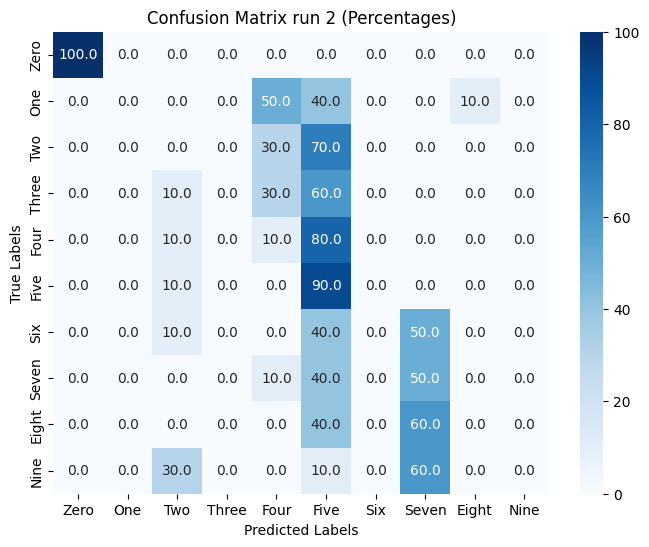

In [ ]:
#Confusion Matrix
conf_matrix = confusion_matrix(Y_test, tm.predict(X_test))
# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percent = np.nan_to_num(conf_matrix_percent, 0)  # Replace NaNs with 0

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 2 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
